### Further datasets

[Time Course Datasets](#timecourse)

#### [Analysis of Other Single Cell Datasets](#scanalysis)

[Kim 2019 cone enriched organoid](#kim2019)

[Macosko 2015 p14 developing retina](#macosko2015) (Dropseq)

[Collin 2019 hESC organoid](#collin2019)

##### [Validation](#validation)

[Kim 2019 cone enriched organoid](#kim2019v)

[Macosko 2015 p14 developing retina](#macosko2015v) (Best results)

##### [Plots](#plots)

[Bulk violin plots](#bulk)

[Single Cell violin plots](#voigt)

In [76]:
%run /booleanfs2/sahoo/Data/Macrophage/BN/bone.py

<Figure size 432x288 with 0 Axes>

In [77]:
import sys
%load_ext autoreload
%autoreload 2
import StepMiner as smn
import HegemonUtil as hu
import re
import numpy as np
import scipy
import math
import itertools
from itertools import combinations 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import statsmodels.stats.proportion
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='timecourse'></a>

### Time Course Datasets

In [22]:
db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
dbid = "RT47"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()
h.getIDs("PDE6B", 1) #idx file too large >100000 lines 
h.getIDs("NR2E3", 1)
h.getIDs("PPEF2", 1)
Pde6b = h.getExprData("Pde6b")
Pde6b = [float(Pde6b[i]) for i in h.aRange()]
Nr2e3 = h.getExprData("NR2E3")
Nr2e3 = [float(Nr2e3[i]) for i in h.aRange()]
Ppef2 = h.getExprData("PPEF2")
Ppef2 = [float(Ppef2[i]) for i in h.aRange()]

In [23]:
atype = h.getSurvName("c post-natal age")
P2 = np.array([i for i in h.aRange() if atype[i] == "P2"])
P4 = np.array([i for i in h.aRange() if atype[i] == "P4"])
P6 = np.array([i for i in h.aRange() if atype[i] == "P6"])
P10 = np.array([i for i in h.aRange() if atype[i] == "P10"])
P12 = np.array([i for i in h.aRange() if atype[i] == "P12"])
P21 = np.array([i for i in h.aRange() if atype[i] == "P21"])
P28 = np.array([i for i in h.aRange() if atype[i] == "P28"])
surv = [P2,P4,P6,P10,P12,P21,P28]

In [75]:
Pde6b_surv = []
for i in range(len(surv)):
    Pde6b_surv.append(np.mean(np.array([Pde6b[a] for a in surv[i]])))

Ppef2_surv = []
for i in range(len(surv)):
    Ppef2_surv.append(np.mean(np.array([Ppef2[a] for a in range(len(Ppef2)) if a in surv[i]])))

Nr2e3_surv = []
for i in range(len(surv)):
    Nr2e3_surv.append(np.mean(np.array([Nr2e3[a] for a in range(len(Nr2e3)) if a in surv[i]])))


'Pde6b_surv = []\nfor i in range(len(surv)):\n    Pde6b_surv.append(np.mean(np.array([Pde6b[a] for a in surv[i]])))\n\nPpef2_surv = []\nfor i in range(len(surv)):\n    Ppef2_surv.append(np.mean(np.array([Ppef2[a] for a in range(len(Ppef2)) if a in surv[i]])))\n\nNr2e3_surv = []\nfor i in range(len(surv)):\n    Nr2e3_surv.append(np.mean(np.array([Nr2e3[a] for a in range(len(Nr2e3)) if a in surv[i]])))\n    '

<a id = 'scanalysis'></a>

## Other single cell datasets

In [3]:
def getBooleanRels(gene1, gene2, arr=None):
    res1 = h.getBooleanRelations(gene1, arr)
    res2 = h.getBooleanRelations(gene2, arr)

    l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
    l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
    l3 = [i[0] for i in l1]
    l4 = [i[0] for i in l2]
    print (dict((x,l3.count(x)) for x in set(l3)))
    print (dict((x,l4.count(x)) for x in set(l4)))
    res3 = [res1[i][1] for i in range(len(res1)) \
            if (l3[i] == 2 or l3[i] == 5) and \
            (l4[i] == 3 or l4[i] == 5)]
    return(res3)

def getBooleanRels2(gene1, gene2, sthr=2.5, pthr=0.35, arr=None):
    res1 = h.getBooleanRelations(gene1, arr)
    res2 = h.getBooleanRelations(gene2, arr)

    l1 = [hu.getBooleanRelationType(i[2], sthr, pthr) for i in res1]
    l2 = [hu.getBooleanRelationType(i[2], sthr, pthr) for i in res2]
    l3 = [i[0] for i in l1]
    l4 = [i[0] for i in l2]
    print (dict((x,l3.count(x)) for x in set(l3)))
    print (dict((x,l4.count(x)) for x in set(l4)))
    res3 = [res1[i][1] for i in range(len(res1)) \
            if (l3[i] == 2 or l3[i] == 5) and \
            (l4[i] == 3 or l4[i] == 5)]
    return(res3)

def getBaitStats(db, dbid, idstr1, sthr=2.5, pthr=0.35, arr=None):
    db = hu.Database(db)
    h = hu.Hegemon(db.getDataset(dbid))
    h.init()
    h.initPlatform()
    h.initSurv()
    bait_dict = {}
    print(idstr1)
    bait_list = itertools.permutations(idstr1, 2)
    for a in bait_list:
        res1 = h.getBooleanRelations2(a[0], arr)
        res2 = h.getBooleanRelations2(a[1], arr)
        l1 = [hu.getBooleanRelationType(i[2], sthr, pthr) for i in res1]
        l2 = [hu.getBooleanRelationType(i[2], sthr, pthr) for i in res2]
        l3 = [i[0] for i in l1]
        l4 = [i[0] for i in l2]
        res3 = [res1[i][1] for i in range(len(res1)) \
                if (l3[i] == 2 or l3[i] == 5) and \
                (l4[i] == 3 or l4[i] == 5)]

        res3 = set(res3)
        res4 = list(set(idstr1).difference(set(res3))) # no. of starred genes omitted 
        bait_dict[a] = [len(res4), len(res3)] #[no. of starred genes omitted, total number of genes]
    return(bait_dict)

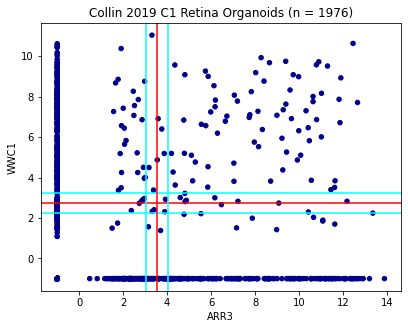

In [33]:
obj = hu.getHegemonPlots("RT24", "ARR3", "WWC1")
hu.plotBooleanPair(obj[0])

<a id = 'kim2019'></a>

### Kim 2019 cone enriched organoid

In [51]:
#Kim 2019 cone enriched organoid
#ARR3 and GNAT2 (cones)
db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
dbid = "RT37"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

res1 = h.getBooleanRelations2("ARR3")
res2 = h.getBooleanRelations2("GNAT2")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5) and \
        (l4[i] == 3 or l4[i] == 5)]
print('res3 : all')
print (" ".join(sorted(res3)))


{0: 21817, 1: 4, 2: 1374, 3: 16, 4: 19, 5: 3}
{0: 19716, 2: 2964, 3: 497, 4: 37, 5: 18, 6: 1}
res3 : all
ARMC9 ARR3 BRP44 C10orf58 C12orf62 C22orf32 C5orf13 CBWD1 CC2D2A CCDC28B CCDC82 CDHR1 COX7B CPLX4 DZIP3 FAM138E GNAT2 GUCA1C HOOK1 IER3IP1 IFT57 KIF2A LYPLA1 MAK MAP4 MAP6 MDH2 MGST3 MPP4 MRPL53 MYL4 NDRG3 NDUFA8 NDUFA9 NHP2 PCP4 PDE6D PDE6H PDHA1 PGRMC1 PRCD RABL3 RABL5 RD3 RGS9 RS1 RUFY3 SCAMP1 SIX6 STX3 SUPT16H TMEM14A TULP1


In [10]:
cone_gs = ['ARR3','GNAT2','GNB3', 'GNGT2', 'PDE6H', "OPN1SW"]
bait_dict = getBaitStats("/booleanfs2/sahoo/Hegemon/explore.conf", "RT37", cone_gs)

['ARR3', 'GNAT2', 'GNB3', 'GNGT2', 'PDE6H', 'OPN1SW']


In [11]:
bait_dict

{('ARR3', 'GNAT2'): [3, 53],
 ('ARR3', 'GNB3'): [6, 0],
 ('ARR3', 'GNGT2'): [5, 3],
 ('ARR3', 'PDE6H'): [4, 3],
 ('ARR3', 'OPN1SW'): [6, 0],
 ('GNAT2', 'ARR3'): [6, 0],
 ('GNAT2', 'GNB3'): [6, 0],
 ('GNAT2', 'GNGT2'): [6, 0],
 ('GNAT2', 'PDE6H'): [6, 0],
 ('GNAT2', 'OPN1SW'): [6, 0],
 ('GNB3', 'ARR3'): [3, 16],
 ('GNB3', 'GNAT2'): [1, 191],
 ('GNB3', 'GNGT2'): [3, 70],
 ('GNB3', 'PDE6H'): [2, 21],
 ('GNB3', 'OPN1SW'): [6, 0],
 ('GNGT2', 'ARR3'): [5, 2],
 ('GNGT2', 'GNAT2'): [3, 174],
 ('GNGT2', 'GNB3'): [6, 0],
 ('GNGT2', 'PDE6H'): [4, 3],
 ('GNGT2', 'OPN1SW'): [6, 0],
 ('PDE6H', 'ARR3'): [4, 4],
 ('PDE6H', 'GNAT2'): [2, 87],
 ('PDE6H', 'GNB3'): [6, 0],
 ('PDE6H', 'GNGT2'): [4, 11],
 ('PDE6H', 'OPN1SW'): [6, 0],
 ('OPN1SW', 'ARR3'): [6, 0],
 ('OPN1SW', 'GNAT2'): [6, 0],
 ('OPN1SW', 'GNB3'): [6, 0],
 ('OPN1SW', 'GNGT2'): [6, 0],
 ('OPN1SW', 'PDE6H'): [6, 0]}

In [20]:
Arr3_Gnat2_bool_phillips = ['ANKRD33B', 'ARR3', 'C8orf46', 'CERKL', 'EGFLAM', 'FGF12', 'FMN1', 'GNAT2', 'GNGT2', 'GPR180',
                            'HCN1', 'HEG1', 'MAGEE1', 'MAOA', 'MLXIP', 'NDNF', 'PDZD2', 'PEX5L', 'RD3', 'RS1', 'RXRG',
                            'SEMA3C', 'SH3GL2', 'SLC1A7', 'SLC24A2', 'STXBP5L', 'SVOP', 'TRIM59', 'UBAP1L', 'WWC1',
                            'XRCC4']
                            
Crx_Prdm1_Rxrg_Thrb_corr_phillips = ['AIPL1','CADM2','CPE','DST', 'FAM123A', 'GUCA1A', 'LPCAT1', 'NEUROD4','PLEKHB1',
                                     'RCVRN', 'RXRG', 'SLC40A1', 'SYT1', 'ANKRD33B', 'CDHR1', 'CPLX4', 'EGFLAM',
                                     'GABRR2', 'IMPG1', 'MAK', 'OTX2','PRDM1', 'RD3', 'SEPT4', 'SLC6A6', 'THRB',
                                     'ARL6', 'CERKL', 'CRX', 'EML1', 'GNAT2', 'IMPG2','MAOA', 'PDC', 'PROM1', 'RP1',
                                     'SGIP1', 'SNAP25', 'UNC119', 'ARR3', 'CHRNA3', 'DCT', 'ENO2','GNB3','KCNV2',
                                     'MPP4', 'PDE6H', 'RAPGEF4', 'RPGRIP1', 'SLC17A7', 'STX3', 'USH2A', 'CACNB2',
                                     'CHRNA5', 'DLG4', 'EYS', 'GNGT2', 'LBH', 'NEUROD1', 'PEX5L', 'RBP3', 'RS1',
                                     'SLC1A7', 'SYP','VTN', 'AKAP9', 'ARMC9', 'C8orf46', 'CADPS', 'FGF12', 'FSTL5',
                                     'ISOC1', 'NCKAP5', 'PRICKLE2', 'SCN3B','SLC38A5', 'TRAK2', 'TUBA4A', 'COBLL1',
                                     'FMN1', 'GALNT13', 'LGALSL', 'NPTX1', 'RALGPS2', 'SEMA3C', 'STXBP5L', 'TRIM36',
                                     'XRCC4', 'FAM57B', 'FRMPD1', 'GPC5', 'MEGF9', 'PCBP4', 'ROBO2', 'SH3GL2', 'TPD52',
                                     'TTC39C']
set(Crx_Prdm1_Rxrg_Thrb_corr_phillips).intersection(res3)

{'ARMC9',
 'ARR3',
 'CDHR1',
 'CPLX4',
 'GNAT2',
 'MAK',
 'MPP4',
 'PDE6H',
 'RD3',
 'RS1',
 'STX3'}

In [78]:
#GNB3 and PDE6H (cones)
db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
dbid = "RT37"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

res1 = h.getBooleanRelations2("GNB3")
res2 = h.getBooleanRelations2("PDE6H")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5) and \
        (l4[i] == 3 or l4[i] == 5)]
print('res3 : all')
print (" ".join(sorted(res3)))


{0: 21663, 1: 15, 2: 1552, 3: 1, 5: 2}
{0: 21515, 1: 18, 2: 1483, 3: 25, 4: 187, 5: 5}
res3 : all
AIPL1 ARR3 CNGB1 ENO2 FSTL5 GNB3 GNGT2 GUCA1A GUCA1B GUCA1C IMPG2 KCNV2 MAP1B MAP2 NEUROD1 PDC PDE6H PLEKHB1 RCVRN RP1 SEPT4


In [87]:
db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
dbid = "RT37"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

res1 = h.getBooleanRelations2("PDE6H")
res2 = h.getBooleanRelations2("GNAT2")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5) and \
        (l4[i] == 3 or l4[i] == 5)]
print('res3 : all')
print (" ".join(sorted(res3)))


{0: 21515, 1: 18, 2: 1483, 3: 25, 4: 187, 5: 5}
{0: 19716, 2: 2964, 3: 497, 4: 37, 5: 18, 6: 1}
res3 : all
ABCA4 ABHD14A ADIPOR1 ALKBH7 ARMC9 ARR3 BCAS2 BRP44 C10orf58 C11orf48 C12orf62 C22orf32 C5orf13 CACYBP CADM2 CBWD1 CC2D2A CCDC28B CCDC82 CDHR1 CHN2 COX7B CPLX4 CRX DCTN3 DPYSL3 DYNLRB1 DZIP3 FAM138E GADD45G GNAT2 GNGT2 GUCA1C HOOK1 HSPA4 IER3IP1 IFT57 IMPG1 KIF2A LYPLA1 MAK MAP1B MAP4 MAP6 MDH2 MGST3 MOAP1 MPP4 MRPL14 MRPL53 MYL4 NDRG3 NDUFA2 NDUFA8 NDUFA9 NHP2 NONO NTM NUCB2 PCP4 PDE6D PDE6H PDHA1 PGRMC1 PPP2R2B PPT1 PRCD PROM1 PTPN13 RABL3 RABL5 RBP3 RD3 RGS9 RS1 RUFY3 SCAMP1 SIX6 SLC38A1 STX3 TMEM14A TULP1 TXNL1 UBA3 UBE2N VPS36 VTN


<a id = 'macosko2015'></a>

### Macosko 2015 P14 mouse retina

In [59]:
#Macosko 2015 P14 mouse retina
#ARR3 and GNAT2 (cones)
db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
dbid = "RT57"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

res1 = h.getBooleanRelations("ARR3")
res2 = h.getBooleanRelations("GNAT2")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5) and \
        (l4[i] == 3 or l4[i] == 5)]
print('res3 : all')
print(res3)

{0: 22365, 2: 97, 3: 360, 4: 1827, 5: 9}
{0: 22775, 2: 112, 3: 339, 4: 1423, 5: 9}
res3 : all
['GNGT2', 'KCNE2', 'PDE6C', 'CD59A', 'GNAT2', 'PDE6H', 'OPN1SW', 'ARR3', 'OPN1MW']


In [67]:
#PDE6B and NR2E3 (rods)
db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
dbid = "RT57"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

res1 = h.getBooleanRelations("PDE6B")
res2 = h.getBooleanRelations("NR2E3")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5) and \
        (l4[i] == 3 or l4[i] == 5)]
print('res3 : all')
print (" ".join(sorted(res3)))

{0: 14415, 1: 14, 2: 1863, 3: 2, 4: 8342, 5: 21, 6: 1}
{0: 14680, 1: 6, 2: 1920, 3: 7, 4: 8029, 5: 16}
res3 : all
CNGA1 CST3 GNAT1 GNB1 GNGT1 NR2E3 NRL PDC PDE6B PDE6G PRPH2 RCVRN RHO ROM1 RP1 RPGRIP1 RS1 SAG SLC24A1 TULP1 UNC119


<a id = 'collin2019'></a>

### Collin 2019 hESC organoid

In [8]:
#Collin 2019 hESC organoid
#PDE6B and NR2E3 (rods)
dbid = "RT24"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

res1 = h.getBooleanRelations2("PDE6B")
res2 = h.getBooleanRelations2("NR2E3")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5) and \
        (l4[i] == 3 or l4[i] == 5)]
print('res3 : all')
print (" ".join(sorted(res3)))

{0: 24267, 2: 16, 3: 95, 4: 36, 5: 1}
{0: 24191, 2: 3, 3: 71, 4: 148, 5: 2}
res3 : all
CNGB1 GNAT1 NR2E3 PDE6B PRPH2 ROM1


In [94]:
#Kallman 2020 nrl-null organoid
#ARR3 and GNAT2 (cones)
db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
dbid = "RT56.2"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

res1 = h.getBooleanRelations("ARR3")
res2 = h.getBooleanRelations("GNAT2")

l1 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res1]
l2 = [hu.getBooleanRelationType(i[2], 2.5, 0.35) for i in res2]
l3 = [i[0] for i in l1]
l4 = [i[0] for i in l2]
print (dict((x,l3.count(x)) for x in set(l3)))
print (dict((x,l4.count(x)) for x in set(l4)))
res3 = [res1[i][1] for i in range(len(res1)) \
        if (l3[i] == 2 or l3[i] == 5) and \
        (l4[i] == 3 or l4[i] == 5)]
print('res3 : all')
print(res3)

{0: 34571, 2: 336, 3: 130, 4: 2236, 5: 4}
{0: 35321, 2: 51, 3: 184, 4: 1720, 5: 1}
res3 : all
['ARR3', 'GNAT2', 'GUCA1A', 'GUCA1B', 'GUCA1C']


<a id = 'validation'></a>

## Validation

In [2]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT40"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c tissue")
cones = [i for i in h.aRange() if atype[i] == "Cones"]
rods = [i for i in h.aRange() if atype[i] == "Rods"]
PR = [i for i in h.aRange() if atype[i] == "Cones" or atype[i] == "Rods"]
retina = [i for i in h.aRange() if atype[i] != "Cones" and atype[i] != "Rods"]

In [21]:
def passDict(res, atype1, atype2, mean_thr):
    boolean_dict = {}
    allIDs = np.array(list(h.getAllIDs()))
    allNames = np.array([h.getName(i) for i in allIDs])
    upperNames = np.array([i.upper() for i in allNames])
    for i in res:
        if i in upperNames:
            expr = h.getExprData(i)
            expr_cones = np.array([math.nan if expr[x] == '' else float(expr[x]) for x in atype1])
            expr_rods = np.array([math.nan if expr[x] == '' else float(expr[x]) for x in atype2])
            boolean_dict[i] = [scipy.stats.ttest_ind(expr_rods, expr_cones, equal_var = False, nan_policy = 'omit'), \
                               (np.nanmean(expr_cones)-np.nanmean(expr_rods))]
    pass_dict = {i:boolean_dict[i] for i in list(boolean_dict.keys()) if boolean_dict[i][0].statistic<0 and \
            boolean_dict[i][0].pvalue/2 < 0.05 and boolean_dict[i][1] > mean_thr}
    print(pass_dict)
    print(len(pass_dict))
    print(len(res))
    print(len(pass_dict)/len(res))
    return(pass_dict)

In [30]:
allIDs = np.array(list(h.getAllIDs()))
allNames = np.array([h.getName(i) for i in allIDs])
print(allNames)

['Trdd2' 'Trdd1' 'Trbd2' ... 'Gm27300' 'Gm27350' 'Gm23954']


<a id = 'kim2019v'></a>

### Kim 2019

In [61]:
#Kim 2019 - ARR3 and GNAT2
res3 = ['ARMC9', 'ARR3', 'BRP44', 'C10orf58', 'C12orf62', 'C22orf32', 'C5orf13', 'CBWD1', 'CC2D2A', 'CCDC28B', 'CCDC82', 'CDHR1', 'COX7B', 'CPLX4', 'DZIP3', 'FAM138E', 'GNAT2', 'GUCA1C', 'HOOK1', 'IER3IP1', 'IFT57', 'KIF2A', 'LYPLA1', 'MAK', 'MAP4', 'MAP6', 'MDH2', 'MGST3', 'MPP4', 'MRPL53', 'MYL4', 'NDRG3', 'NDUFA8', 'NDUFA9', 'NHP2', 'PCP4', 'PDE6D', 'PDE6H', 'PDHA1', 'PGRMC1', 'PRCD', 'RABL3', 'RABL5', 'RD3', 'RGS9', 'RS1', 'RUFY3', 'SCAMP1', 'SIX6', 'STX3', 'SUPT16H', 'TMEM14A', 'TULP1']

In [52]:
#Kim 2019 - ARR3 and GNAT2 - Filtered
res3 = ['ARMC9','ARR3','CDHR1','CPLX4','GNAT2','MAK','MPP4','PDE6H','RD3','RS1','STX3']

In [64]:
kim_pass_dict = passDict(res3, cones, rods, 0.5)

{'ARR3': [Ttest_indResult(statistic=-79.47782271808329, pvalue=1.392089055880032e-07), 7.860621455817347], 'CDHR1': [Ttest_indResult(statistic=-18.22621644096892, pvalue=2.3592963772632424e-05), 1.0647229869650623], 'COX7B': [Ttest_indResult(statistic=-12.921865313608622, pvalue=2.0799674184162665e-05), 1.0287470456843337], 'DZIP3': [Ttest_indResult(statistic=-3.966828679316516, pvalue=0.01997899811167998), 0.797522118636107], 'GNAT2': [Ttest_indResult(statistic=-42.17945828800873, pvalue=1.097856409312427e-05), 7.61193431808611], 'MAP6': [Ttest_indResult(statistic=-50.751123932444344, pvalue=4.328994819070613e-09), 5.8454743674438], 'MGST3': [Ttest_indResult(statistic=-29.319205748439554, pvalue=2.1677937233147593e-07), 3.6755442796903153], 'NDUFA8': [Ttest_indResult(statistic=-10.869653874026973, pvalue=0.0001110860163213268), 0.8045850104301966], 'PCP4': [Ttest_indResult(statistic=-2.099023622000372, pvalue=0.09340249568326077), 0.6218929613642485], 'PDE6D': [Ttest_indResult(statist

In [82]:
#Kim 2019 - GNB3 and PDE6H
res3 = ['AIPL1', 'ARR3', 'CNGB1', 'ENO2', 'FSTL5', 'GNB3', 'GNGT2', 'GUCA1A', 'GUCA1B', 'GUCA1C', 'IMPG2', 'KCNV2', 'MAP1B', 'MAP2', 'NEUROD1', 'PDC', 'PDE6H', 'PLEKHB1', 'RCVRN', 'RP1', 'SEPT4']

In [86]:
kim_pass_dict = passDict(res3, cones, rods, 0.5)

{'AIPL1': [Ttest_indResult(statistic=-18.96612511957559, pvalue=1.388718930541246e-06), 0.5655183384407998], 'ARR3': [Ttest_indResult(statistic=-79.47782271808329, pvalue=1.392089055880032e-07), 7.860621455817347], 'ENO2': [Ttest_indResult(statistic=-12.464296640181955, pvalue=7.213026933763722e-05), 0.7668994677021974], 'FSTL5': [Ttest_indResult(statistic=-3.9379632914248717, pvalue=0.016987683126720755), 1.063858412777639], 'GNB3': [Ttest_indResult(statistic=-84.32744852342711, pvalue=1.1546236898060018e-06), 5.110050670318478], 'GNGT2': [Ttest_indResult(statistic=-42.90753865948434, pvalue=3.050534538914067e-06), 7.54406378198434], 'PDE6H': [Ttest_indResult(statistic=-81.56723867859719, pvalue=7.285821742603861e-10), 7.703247406948863], 'PLEKHB1': [Ttest_indResult(statistic=-17.159417205162082, pvalue=1.9002014945846256e-05), 1.5239245366072236]}
8
21
0.38095238095238093


In [92]:
#Kim 2019 - PDE6H and GNAT2
res3 = ['ABCA4', 'ABHD14A', 'ADIPOR1', 'ALKBH7', 'ARMC9', 'ARR3', 'BCAS2', 'BRP44', 'C10orf58', 'C11orf48', 'C12orf62', 'C22orf32', 'C5orf13', 'CACYBP', 'CADM2', 'CBWD1', 'CC2D2A', 'CCDC28B', 'CCDC82', 'CDHR1', 'CHN2', 'COX7B', 'CPLX4', 'CRX', 'DCTN3', 'DPYSL3', 'DYNLRB1', 'DZIP3', 'FAM138E', 'GADD45G', 'GNAT2', 'GNGT2', 'GUCA1C', 'HOOK1', 'HSPA4', 'IER3IP1', 'IFT57', 'IMPG1', 'KIF2A', 'LYPLA1', 'MAK', 'MAP1B', 'MAP4', 'MAP6', 'MDH2', 'MGST3', 'MOAP1', 'MPP4', 'MRPL14', 'MRPL53', 'MYL4', 'NDRG3', 'NDUFA2', 'NDUFA8', 'NDUFA9', 'NHP2', 'NONO', 'NTM', 'NUCB2', 'PCP4', 'PDE6D', 'PDE6H', 'PDHA1', 'PGRMC1', 'PPP2R2B', 'PPT1', 'PRCD', 'PROM1', 'PTPN13', 'RABL3', 'RABL5', 'RBP3', 'RD3', 'RGS9', 'RS1', 'RUFY3', 'SCAMP1', 'SIX6', 'SLC38A1', 'STX3', 'TMEM14A', 'TULP1', 'TXNL1', 'UBA3', 'UBE2N', 'VPS36', 'VTN']
kim_pass_dict = passDict(res3, cones, rods, 0.5)

{'ARR3': [Ttest_indResult(statistic=-79.47782271808329, pvalue=1.392089055880032e-07), 7.860621455817347], 'CDHR1': [Ttest_indResult(statistic=-18.22621644096892, pvalue=2.3592963772632424e-05), 1.0647229869650623], 'COX7B': [Ttest_indResult(statistic=-12.921865313608622, pvalue=2.0799674184162665e-05), 1.0287470456843337], 'DYNLRB1': [Ttest_indResult(statistic=-17.307443183765184, pvalue=4.200395484182831e-06), 0.912954908224199], 'DZIP3': [Ttest_indResult(statistic=-3.966828679316516, pvalue=0.01997899811167998), 0.797522118636107], 'GNAT2': [Ttest_indResult(statistic=-42.17945828800873, pvalue=1.097856409312427e-05), 7.61193431808611], 'GNGT2': [Ttest_indResult(statistic=-42.90753865948434, pvalue=3.050534538914067e-06), 7.54406378198434], 'MAP6': [Ttest_indResult(statistic=-50.751123932444344, pvalue=4.328994819070613e-09), 5.8454743674438], 'MGST3': [Ttest_indResult(statistic=-29.319205748439554, pvalue=2.1677937233147593e-07), 3.6755442796903153], 'NDUFA2': [Ttest_indResult(stati

<a id = 'macosko2015v'></a>

### Macosko 2015

In [100]:
#Macosko Dataset - ARR3 and gNAT2 (CONES)

#Cones vs rods
res3 = ['GNGT2', 'KCNE2', 'PDE6C', 'CD59A', 'GNAT2', 'PDE6H', 'OPN1SW', 'ARR3', 'OPN1MW']
macosko_cones_pass_dict = passDict(res3, cones, rods, 0.5)

{'GNGT2': [Ttest_indResult(statistic=-42.90753865948434, pvalue=3.050534538914067e-06), 7.54406378198434], 'KCNE2': [Ttest_indResult(statistic=-39.410067019903956, pvalue=7.863169749412578e-06), 7.552230902619944], 'PDE6C': [Ttest_indResult(statistic=-36.63435742595173, pvalue=4.199837434312335e-06), 7.567799469607138], 'CD59A': [Ttest_indResult(statistic=-23.99269000926941, pvalue=2.670034714825368e-05), 2.1184671320928015], 'GNAT2': [Ttest_indResult(statistic=-42.17945828800873, pvalue=1.097856409312427e-05), 7.61193431808611], 'PDE6H': [Ttest_indResult(statistic=-81.56723867859719, pvalue=7.285821742603861e-10), 7.703247406948863], 'OPN1SW': [Ttest_indResult(statistic=-38.57803550869581, pvalue=2.6962275256182126e-07), 7.505213879937738], 'ARR3': [Ttest_indResult(statistic=-79.47782271808329, pvalue=1.392089055880032e-07), 7.860621455817347], 'OPN1MW': [Ttest_indResult(statistic=-37.02460787580087, pvalue=1.6887857738191584e-06), 7.9591525714763325]}
9
9
1.0


In [102]:
#CONES vs whole retina
macosko_cones_pass_dict_all = passDict(res3, cones, retina, 0.5)

{'GNGT2': [Ttest_indResult(statistic=-21.082035850768452, pvalue=2.91668266722566e-06), 8.482599581356336], 'KCNE2': [Ttest_indResult(statistic=-18.802359938568525, pvalue=5.657332898500436e-06), 7.729108812621174], 'PDE6C': [Ttest_indResult(statistic=-21.65398318776655, pvalue=1.7575026758678864e-06), 7.98262787971278], 'CD59A': [Ttest_indResult(statistic=-4.66536410802646, pvalue=0.004532214618568348), 1.9603469670871085], 'GNAT2': [Ttest_indResult(statistic=-23.111664718596867, pvalue=2.111641274700949e-06), 8.044032580957035], 'PDE6H': [Ttest_indResult(statistic=-19.568615162444136, pvalue=4.856592176270217e-06), 8.958819493369047], 'OPN1SW': [Ttest_indResult(statistic=-15.650622289006744, pvalue=1.1468298291414323e-05), 8.58373977860293], 'ARR3': [Ttest_indResult(statistic=-23.13558605089219, pvalue=2.300544351504061e-06), 8.741305714378857], 'OPN1MW': [Ttest_indResult(statistic=-19.245150606776146, pvalue=2.8795614446159736e-06), 7.846632075647702]}
9
9
1.0


In [98]:
#PDE6B, NR2E3

#Rods vs cones
res4 = ['PDE6G', 'RCVRN', 'UNC119', 'RPGRIP1', 'NRL', 'TULP1', 'PRPH2', 'ROM1', 'PDC', 'RP1', 'SAG', 'CST3', 'GNB1', 'PDE6B', 'CNGA1', 'RHO', 'GNGT1', 'GNAT1', 'NR2E3', 'SLC24A1', 'RS1']
macosko_rods_pass_dict = passDict(res4, rods, cones, 0.5)

{'PDE6G': [Ttest_indResult(statistic=-13.325839550036871, pvalue=1.5147791182474932e-05), 0.5353360800065996], 'RCVRN': [Ttest_indResult(statistic=-6.2589892478346725, pvalue=0.005035271713674501), 0.7112646911962521], 'UNC119': [Ttest_indResult(statistic=-3.441750707028229, pvalue=0.04065656701110069), 0.8480448026932681], 'RPGRIP1': [Ttest_indResult(statistic=-12.486969948925545, pvalue=0.0001556540319879758), 0.663433531851835], 'NRL': [Ttest_indResult(statistic=-58.5035088276976, pvalue=2.0019760540760066e-09), 3.9262786567997336], 'PRPH2': [Ttest_indResult(statistic=-28.239619404089606, pvalue=7.965000676118669e-06), 1.7593195916188495], 'ROM1': [Ttest_indResult(statistic=-15.187874806510518, pvalue=9.957852202934957e-05), 2.240489608040315], 'PDC': [Ttest_indResult(statistic=-17.362590347676406, pvalue=1.6418627014504507e-05), 1.8696207377343512], 'RP1': [Ttest_indResult(statistic=-27.627563685282755, pvalue=4.612813766671988e-07), 2.7036247567513083], 'SAG': [Ttest_indResult(sta

In [24]:
set(res4).difference(list(macosko_rods_pass_dict.keys()))

{'TULP1'}

In [103]:
#Rods vs whole retina
macosko_rods_pass_dict2 = passDict(res4, rods, retina, 0.5)

{'PDE6G': [Ttest_indResult(statistic=-58.008541274939674, pvalue=3.1381597636705325e-09), 6.561630165943472], 'RCVRN': [Ttest_indResult(statistic=-55.717374220293344, pvalue=5.484569046918184e-09), 7.056770964193835], 'UNC119': [Ttest_indResult(statistic=-24.14238352534956, pvalue=2.0826484893645954e-06), 5.800524783736541], 'RPGRIP1': [Ttest_indResult(statistic=-16.96882289173943, pvalue=1.2240814791932154e-05), 6.369714598342126], 'NRL': [Ttest_indResult(statistic=-92.80696773703288, pvalue=3.0033699033121203e-13), 7.448588161620648], 'TULP1': [Ttest_indResult(statistic=-38.689171233821924, pvalue=7.127445813270246e-08), 6.9398873344263405], 'PRPH2': [Ttest_indResult(statistic=-47.74415355902382, pvalue=1.244890397388915e-09), 7.007633006721263], 'ROM1': [Ttest_indResult(statistic=-51.135047315385386, pvalue=2.715368742321701e-10), 6.719149955974088], 'PDC': [Ttest_indResult(statistic=-46.486242953886986, pvalue=5.159037432208649e-11), 7.228576913705009], 'RP1': [Ttest_indResult(stat

[ 0  8 16 24]


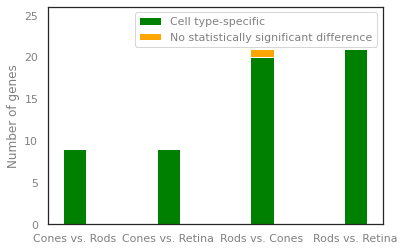

In [138]:
spec = [9,9,20,21]
eq = [0,0,1,0]

ind = np.arange(0, 32, 8)
width = 2
print(ind)
eq_bottom = [spec[i] for i in range(len(spec))]

fig,ax = plt.subplots()
p1 = plt.bar(ind, spec, width, color = "green")
p2 = plt.bar(ind, eq, width,
            bottom=spec, color = "orange")


plt.ylabel("Number of genes")
plt.xticks(ind, ["Cones vs. Rods", "Cones vs. Retina", "Rods vs. Cones", "Rods vs. Retina"])
plt.legend((p1[0], p2[0]), ("Cell type-specific", "No statistically significant difference"))
ax.set(ylim=(0,26))

plt.savefig("/Users/rohan/public_html/Hegemon/macosko.pdf")
plt.show()

[ 0 16]


[(0.0, 26.0)]

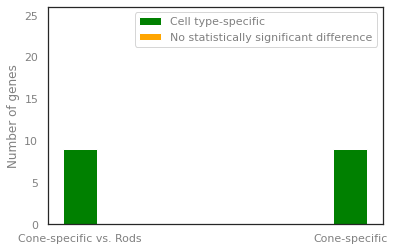

In [137]:
spec = [9,9]
eq = [0,0]

ind = np.arange(0, 32, 16)
width = 2
print(ind)
eq_bottom = [spec[i] for i in range(len(spec))]

fig,ax = plt.subplots()
p1 = plt.bar(ind, spec, width, color = "green")
p2 = plt.bar(ind, eq, width,
            bottom=spec, color = "orange")

plt.ylabel("Number of genes")
plt.xticks(ind, ["Cone-specific vs. Rods", "Cone-specific"])
plt.legend((p1[0], p2[0]), ("Cell type-specific", "No statistically significant difference"))
ax.set(ylim=(0,26))

<a id = 'plots'></a>

### Boxplots, Violin Plots

<a id="bulk"></a>

#### Hartl Dataset Violin Plots

In [131]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT40"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c tissue")
print(hu.uniq(atype))
cones = [i for i in h.aRange() if atype[i] == "Cones"]
rods = [i for i in h.aRange() if atype[i] == "Rods"]
amacrine = [i for i in h.aRange() if atype[i] == "Starbust amacrine cells"]
horizontal = [i for i in h.aRange() if atype[i] == "Horizontal Cells"]

def geneViolinplot(geneName):
    Arr3 = h.getExprData(geneName)
    Arr3_cones = np.array([float(Arr3[i]) for i in cones])
    Arr3_rods = np.array([float(Arr3[i]) for i in rods])
    Arr3_amacrine = np.array([float(Arr3[i]) for i in amacrine])
    Arr3_horizontal = np.array([float(Arr3[i]) for i in horizontal])
    data = [Arr3_cones, Arr3_rods, Arr3_amacrine, Arr3_horizontal]
    Arr3_conedf = pd.DataFrame(data)
    Arr3_conedf = Arr3_conedf.transpose()
    Arr3_conedf.columns = ["Cones", "Rods", "Starbust amacrine", "Horizontal"]
    #print(Arr3_conedf)

    fig, ax = plt.subplots(figsize = (9.5,5))
    ax.set_title(geneName+" (GSE84589, n = 14)")
    ax.set_ylabel(geneName+" Expression")
    sns.violinplot(ax=ax, data=Arr3_conedf)
    return fig

def makeDF(geneName):
    Arr3 = h.getExprData(geneName)
    Arr3_cones = np.array([float(Arr3[i]) for i in cones])
    Arr3_rods = np.array([float(Arr3[i]) for i in rods])
    Arr3_amacrine = np.array([float(Arr3[i]) for i in amacrine])
    Arr3_horizontal = np.array([float(Arr3[i]) for i in horizontal])
    data = [Arr3_cones, Arr3_rods, Arr3_amacrine, Arr3_horizontal]
    Arr3_conedf = pd.DataFrame(data)
    Arr3_conedf = Arr3_conedf.transpose()
    #Arr3_conedf.columns = ["Cones", "Rods", "Starbust amacrine", "Horizontal"]
    #print(Arr3_conedf)
    return(Arr3_conedf)

def saveViolin(geneName, acolor):
    arr3 = makeDF(geneName)
    params = {"dpi":150, "w":2.25*2.5, "h":2*2.5, "acolor":acolor, "vert":1}
    atypes = ["Cones", "Rods", "SA", "HZ"]
    arr3_plot = plotViolin2(arr3, atypes, params)
    return(arr3_plot)

[27, 'c tissue', 'Horizontal Cells', 'Starbust amacrine cells', 'Rods', 'Cones']


In [99]:
%run /Users/rohan/public_html/Hegemon/bone.py

<Figure size 432x288 with 0 Axes>

4


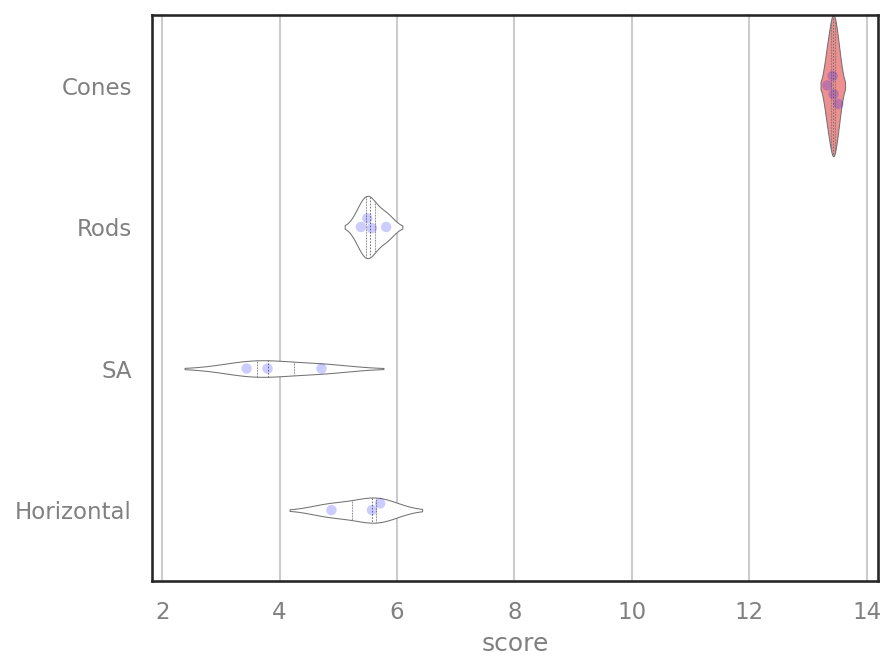

In [89]:
arr3 = makeDF("ARR3")
params = {"dpi":150, "w":2.5*2.5, "h":2*2.5, "acolor":["red","white","white", "white"]}
atypes = ["Cones", "Rods", "SA", "Horizontal"]
arr3_plot = plotViolin2(arr3, atypes, params)

4


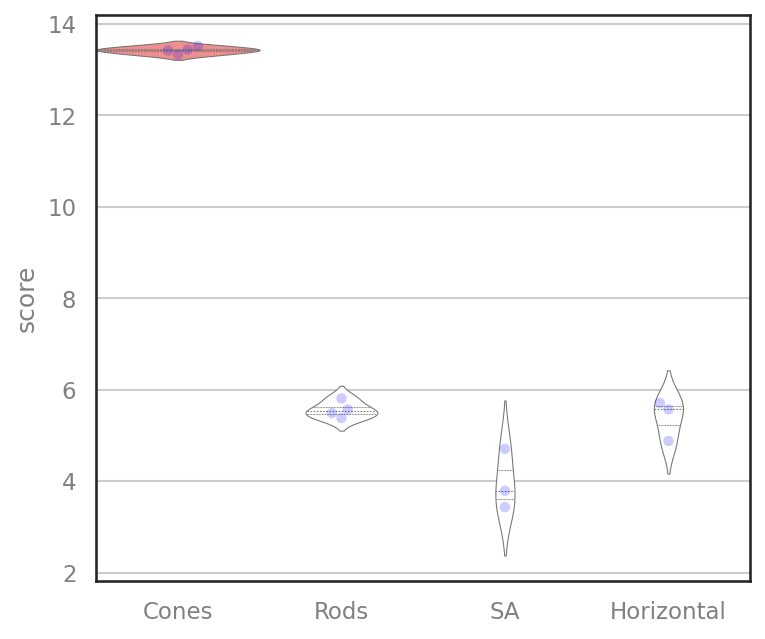

In [104]:
arr3 = makeDF("ARR3")
params = {"dpi":150, "w":2.25*2.5, "h":2*2.5, "acolor":["red","white","white", "white"], "vert":1}
atypes = ["Cones", "Rods", "SA", "Horizontal"]
arr3_plot = plotViolin2(arr3, atypes, params)

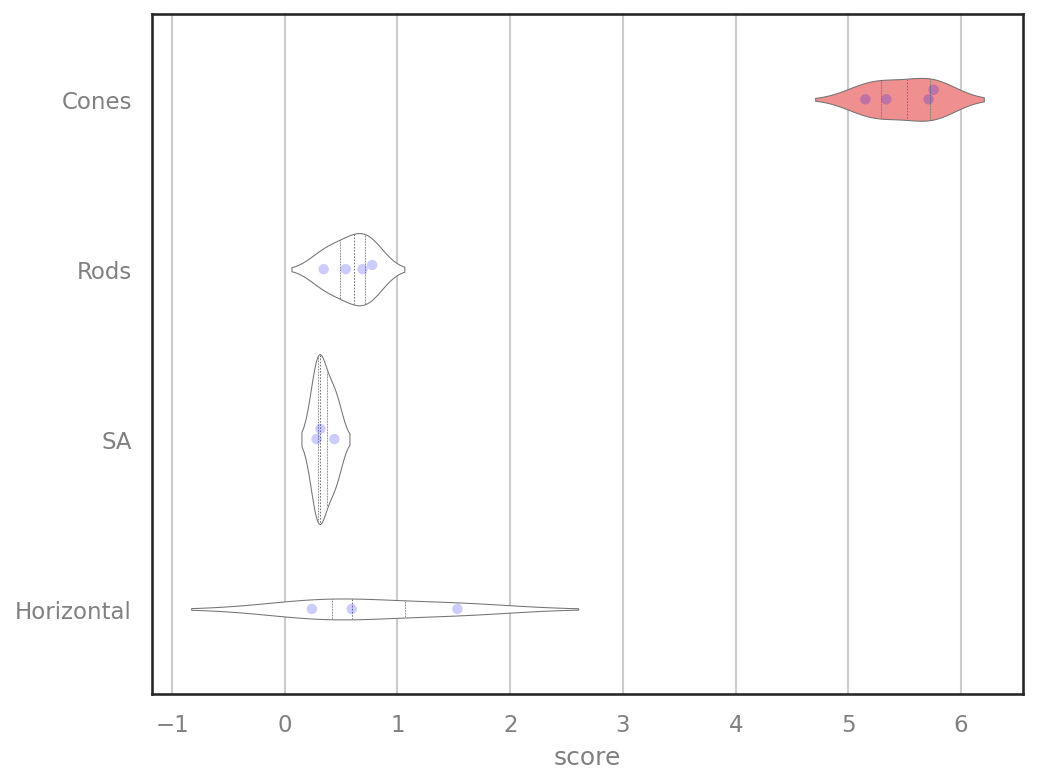

In [114]:
arr3_plot = saveViolin("WWC1",["red","white","white", "white"])

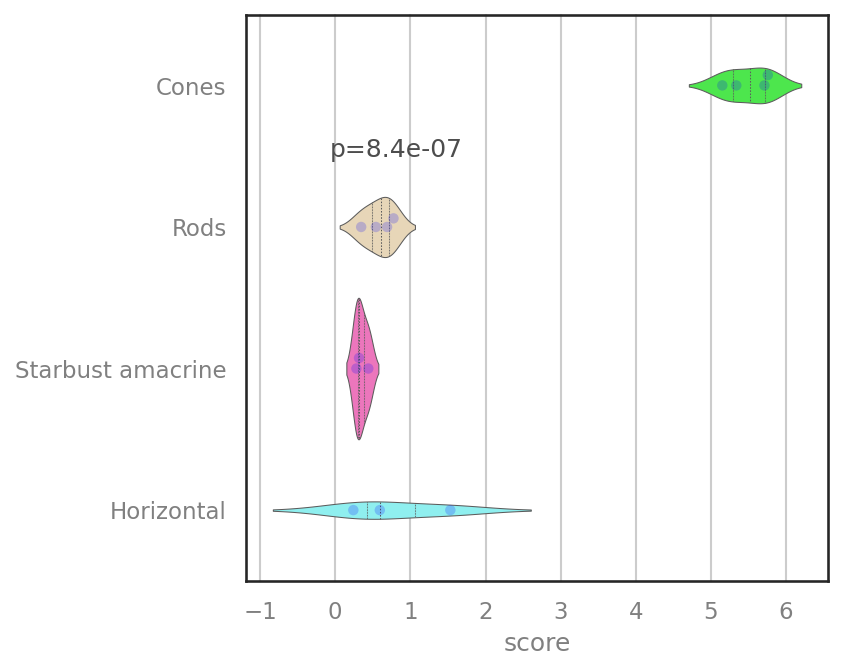

In [136]:
params = {"dpi":150, "w":5, "h":5}
atypes = ["Cones", "Rods", "Starbust amacrine", "Horizontal"]
arr3_plot = plotViolin(arr3, atypes, params)

### Old Plots

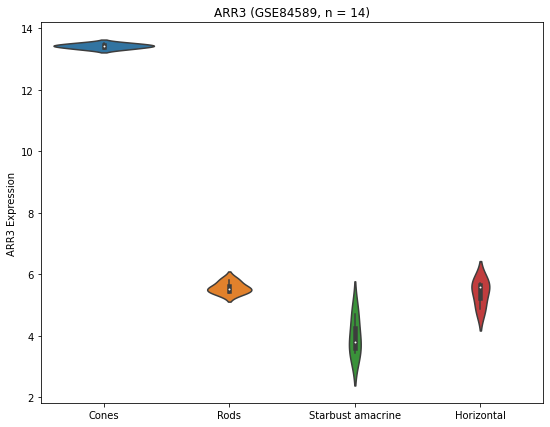

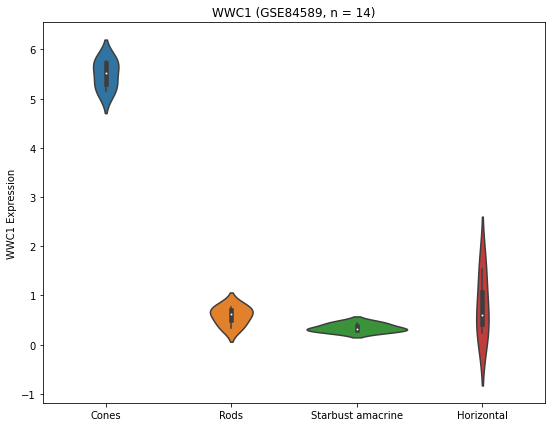

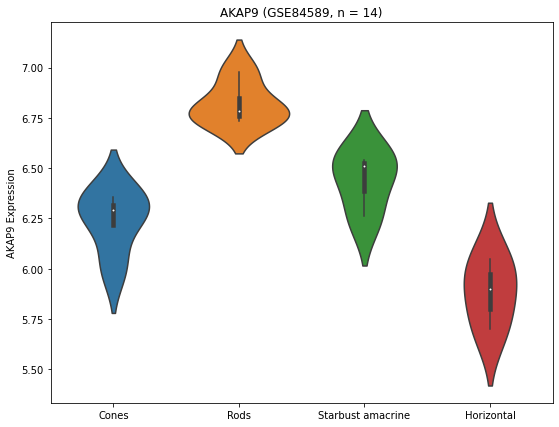

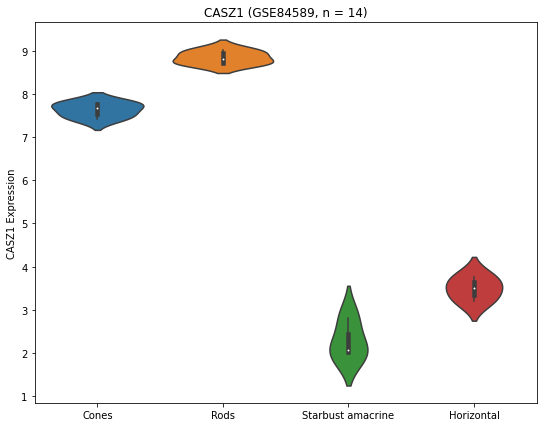

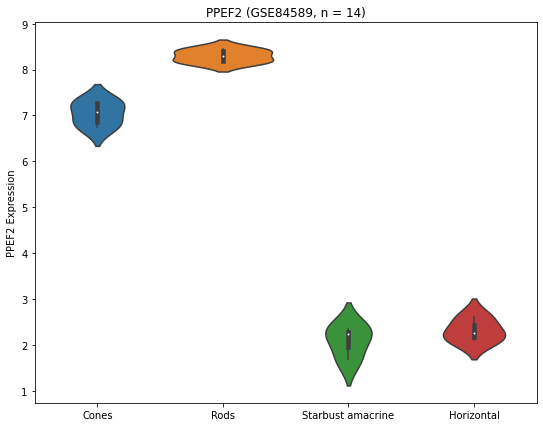

In [98]:
geneViolinplot("ARR3")
geneViolinplot("WWC1")
geneViolinplot("AKAP9")
geneViolinplot("CASZ1")
geneViolinplot("PPEF2")

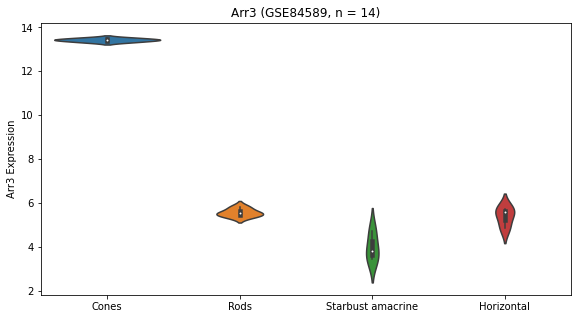

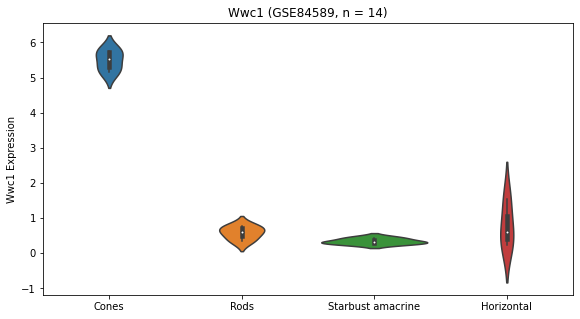

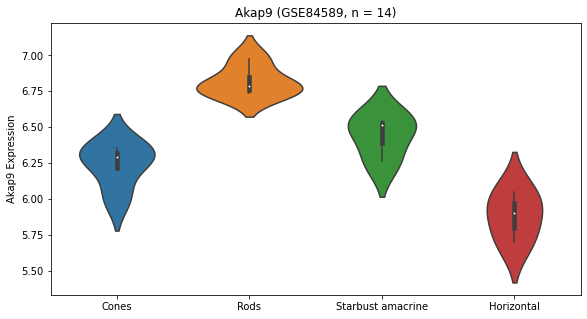

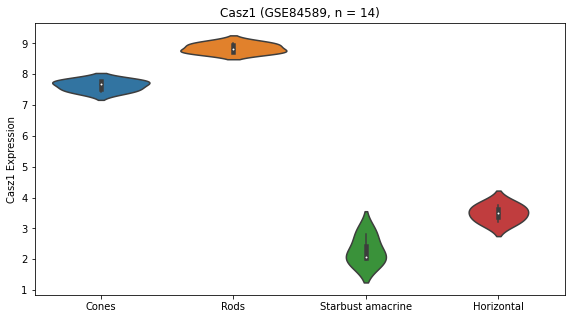

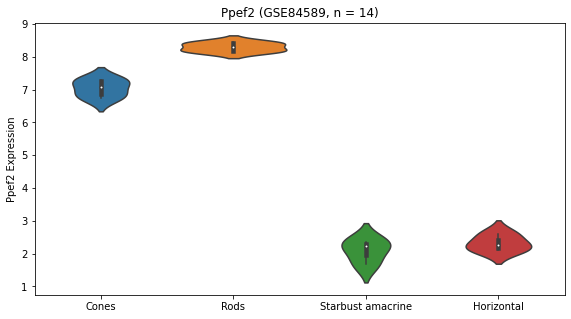

In [36]:
hartl_pdf = PdfPages("hartlPlots.pdf")

arr3_hartl = geneViolinplot("Arr3")
wwc1_hartl = geneViolinplot("Wwc1")
akap9_hartl = geneViolinplot("Akap9")
casz1_hartl = geneViolinplot("Casz1")
ppef2_hartl = geneViolinplot("Ppef2")

hartl_pdf.savefig(arr3_hartl)
hartl_pdf.savefig(wwc1_hartl)
hartl_pdf.savefig(akap9_hartl)
hartl_pdf.savefig(casz1_hartl)
hartl_pdf.savefig(ppef2_hartl)

hartl_pdf.close()

### New Plots

4
4
4
4


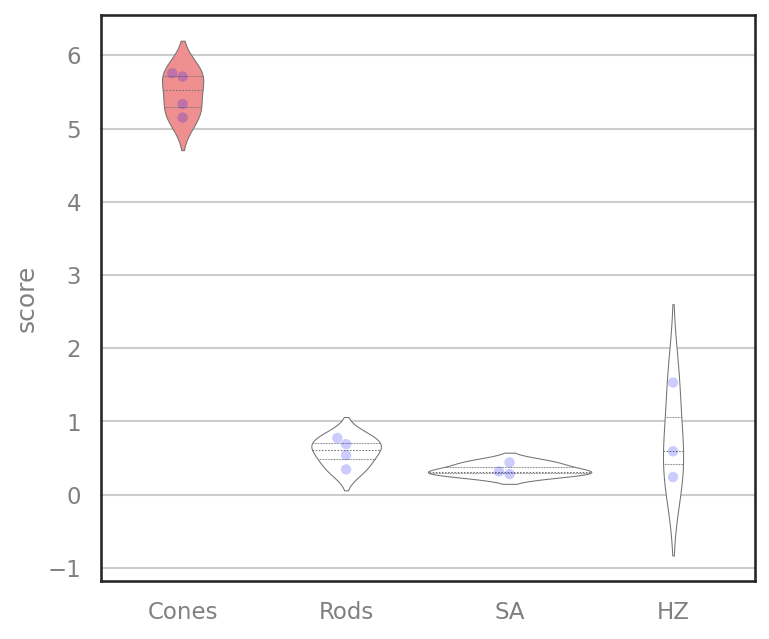

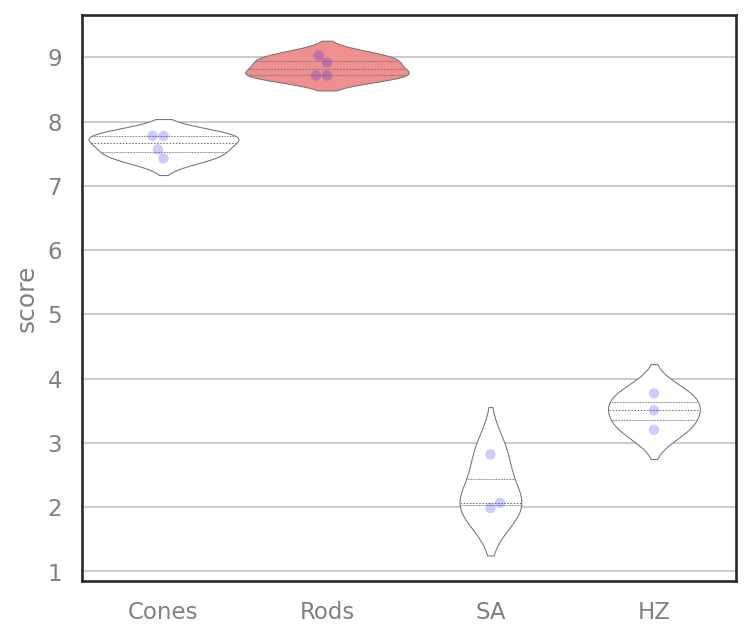

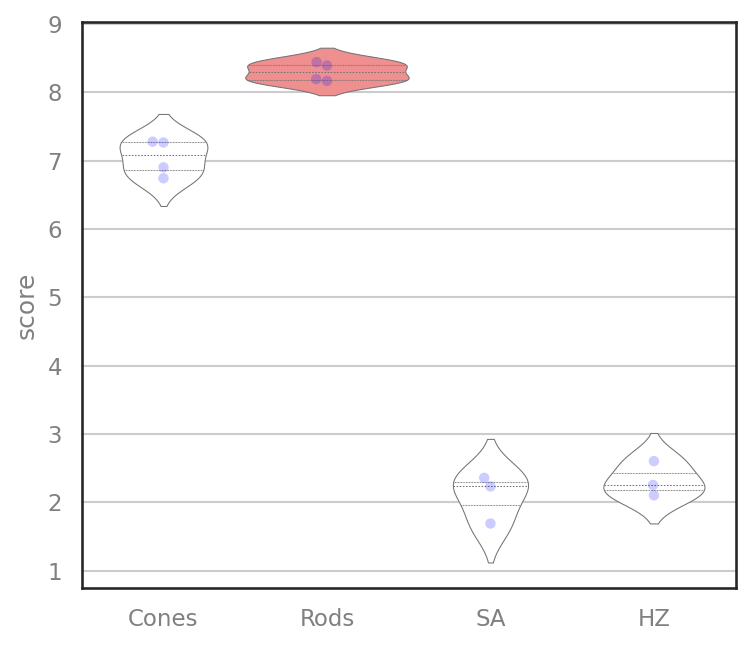

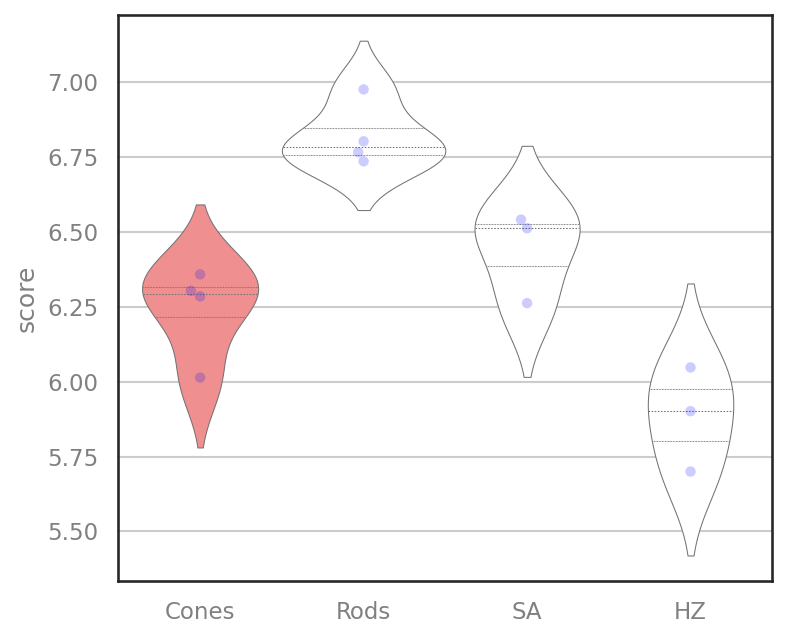

In [132]:
hartl_pdf = PdfPages("hartlPlotsBONE3.pdf")

wwc1_hartl = saveViolin("WWC1",["red","white","white", "white"])
casz1_hartl = saveViolin("CASZ1",["white","red","white", "white"])
ppef2_hartl = saveViolin("PPEF2",["white","red","white", "white"])
akap9_hartl = saveViolin("AKAP9",["red","white","white", "white"])

hartl_pdf.savefig(wwc1_hartl)
hartl_pdf.savefig(casz1_hartl)
hartl_pdf.savefig(ppef2_hartl)
hartl_pdf.savefig(akap9_hartl)
hartl_pdf.close()

## Sarin Dataset Violin Plots

In [112]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT41"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c cell type")
print(hu.uniq(atype))
cones = [i for i in h.aRange() if atype[i] == "Cones"]
rods = [i for i in h.aRange() if atype[i] == "Rods"]
cbipolar = [i for i in h.aRange() if atype[i] == "Cone_bipolars"]
rbipolar = [i for i in h.aRange() if atype[i] == "Rod_bipolars"]
bipolar = [i for i in h.aRange() if atype[i] == "Bipolars"]

def geneViolinplot(geneName):
    expr = h.getExprData(geneName)
    expr_cones = np.array([float(expr[i]) for i in cones])
    expr_rods = np.array([float(expr[i]) for i in rods])
    expr_cbipolar = np.array([float(expr[i]) for i in cbipolar])
    expr_rbipolar = np.array([float(expr[i]) for i in rbipolar])
    expr_bipolar = np.array([float(expr[i]) for i in bipolar])
    
    data = [expr_cones, expr_rods, expr_cbipolar, expr_rbipolar, expr_bipolar]
    expr_df = pd.DataFrame(data)
    expr_df = expr_df.transpose()
    expr_df.columns = ["Cones", "Rods", "Cone Bipolars","Rod Bipolars", "Bipolars"]

    fig, ax = plt.subplots(figsize = (9.5,5))
    ax.set_title(geneName+" (GSE98838, n = 22)")
    ax.set_ylabel(geneName+" Expression")
    sns.violinplot(ax=ax, data=expr_df)
    return fig

[7, 'c cell type', 'Rods', 'Cones', 'Bipolars', 'Rod_bipolars', 'Cone_bipolars']


In [118]:
%run /Users/rohan/public_html/Hegemon/bone.py

<Figure size 432x288 with 0 Axes>

In [129]:
def makeDF(geneName):
    expr = h.getExprData(geneName)
    expr_cones = np.array([float(expr[i]) for i in cones])
    expr_rods = np.array([float(expr[i]) for i in rods])
    expr_cbipolar = np.array([float(expr[i]) for i in cbipolar])
    expr_rbipolar = np.array([float(expr[i]) for i in rbipolar])
    expr_bipolar = np.array([float(expr[i]) for i in bipolar])
    
    data = [expr_cones, expr_rods, expr_bipolar,expr_cbipolar, expr_rbipolar]
    expr_df = pd.DataFrame(data)
    expr_df = expr_df.transpose()
    #print(expr_df)
    return(expr_df)

def saveViolin(geneName, acolor):
    arr3 = makeDF(geneName)
    params = {"dpi":150, "h":2*3, "w":2.25*3, "acolor":acolor, 'vert':1}
    atypes = ["Cones", "Rods", "CBP", "RBP", "BP"]
    arr3_plot = plotViolin3(arr3, 5, atypes, params)
    return(arr3_plot)

### New Plots

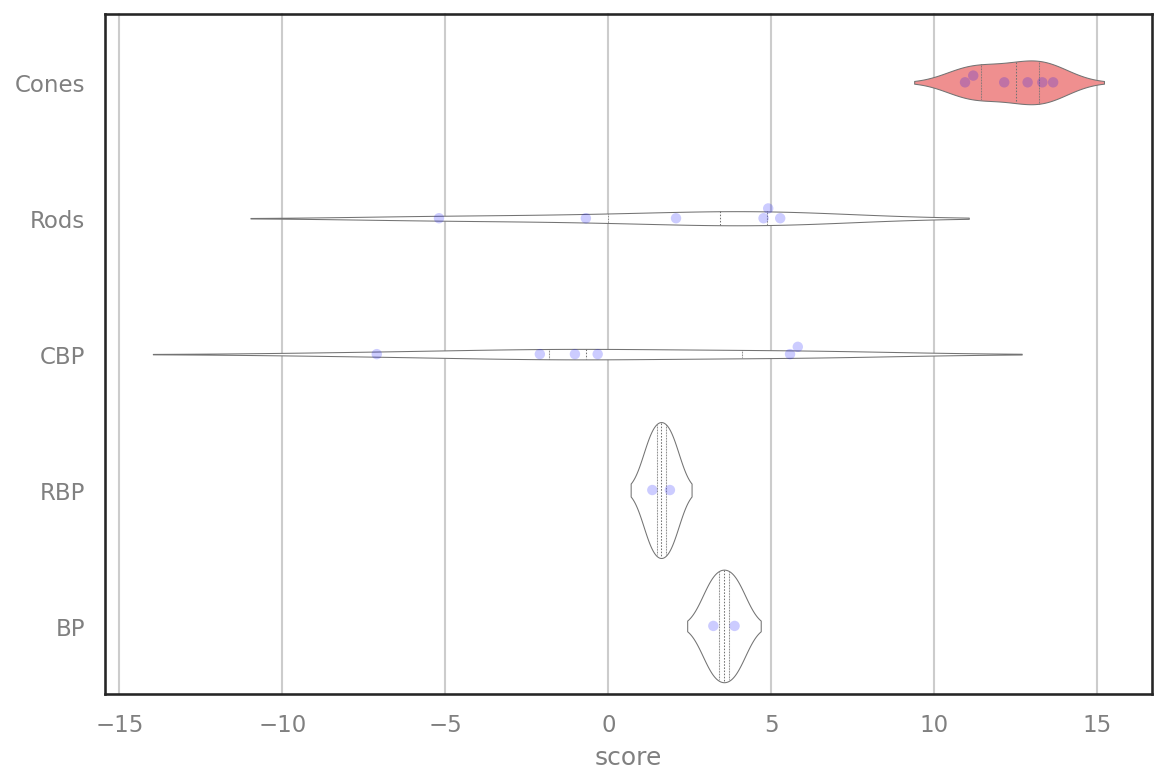

In [116]:
arr3 = makeDF("ARR3")
params = {"dpi":150, "w":3*3, "h":2*3, "acolor":["red","white","white", "white", "white"]}
atypes = ["Cones", "Rods", "CBP", "RBP", "BP"]
arr3_plot = plotViolin3(arr3, 5, atypes, params)

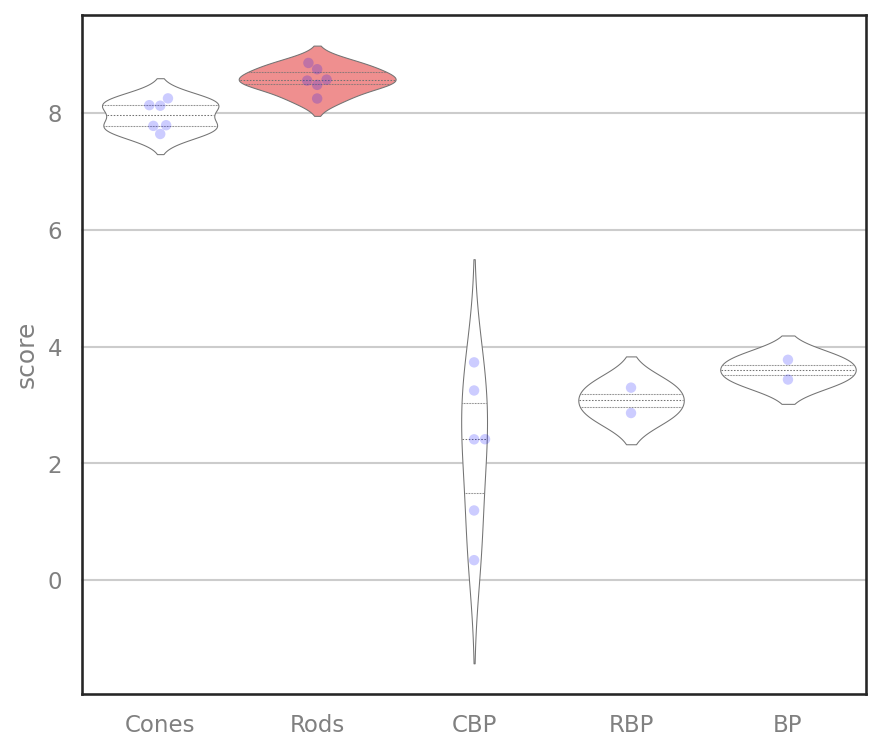

In [128]:
arr3 = makeDF("CASZ1")
params = {"dpi":150, "h":2*3, "w":2.25*3, "acolor":["white","red","white", "white", "white"], 'vert':1}
atypes = ["Cones", "Rods", "CBP", "RBP", "BP"]
arr3_plot = plotViolin3(arr3, 5, atypes, params)

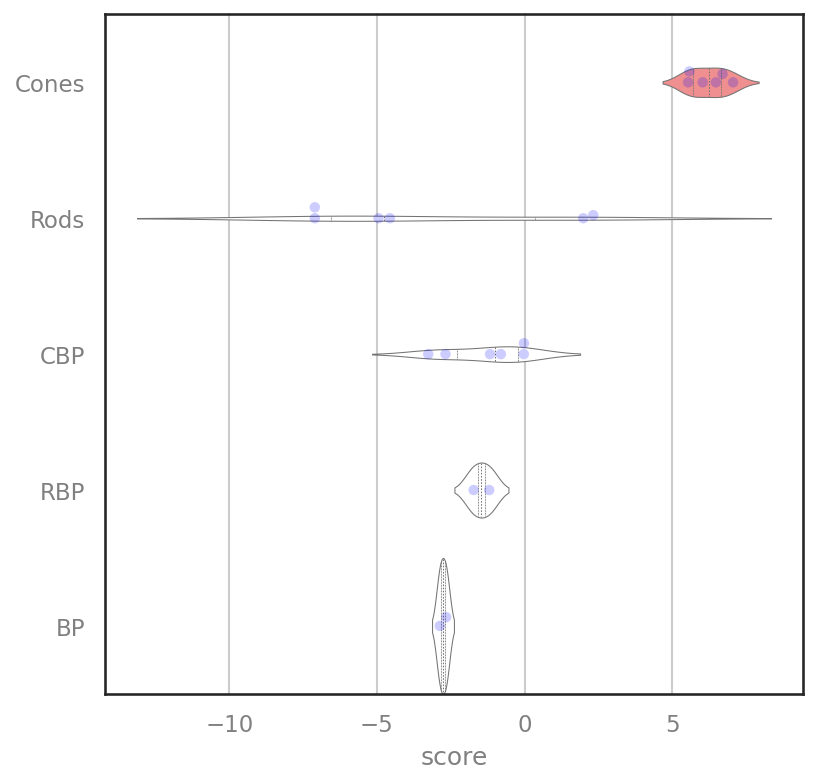

In [205]:
wwc1_sarin = saveViolin("WWC1",["red","white","white", "white", "white"])

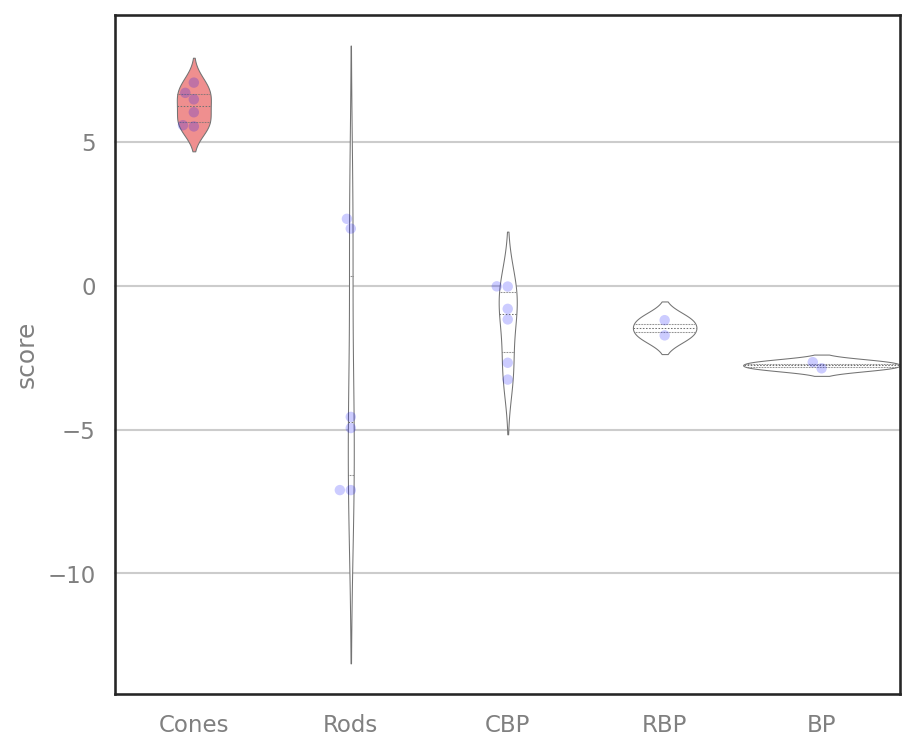

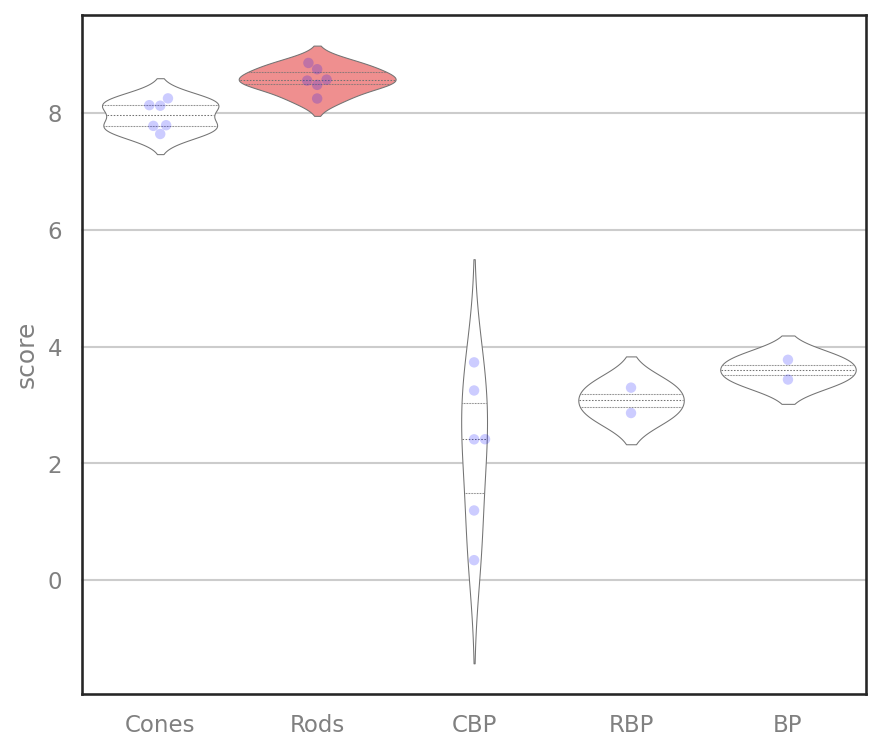

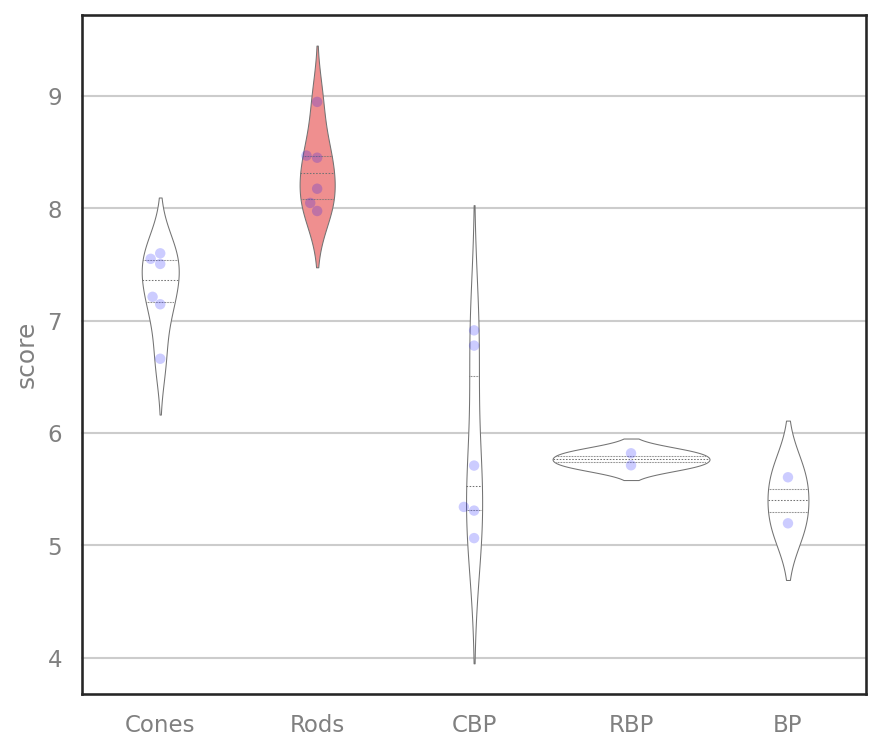

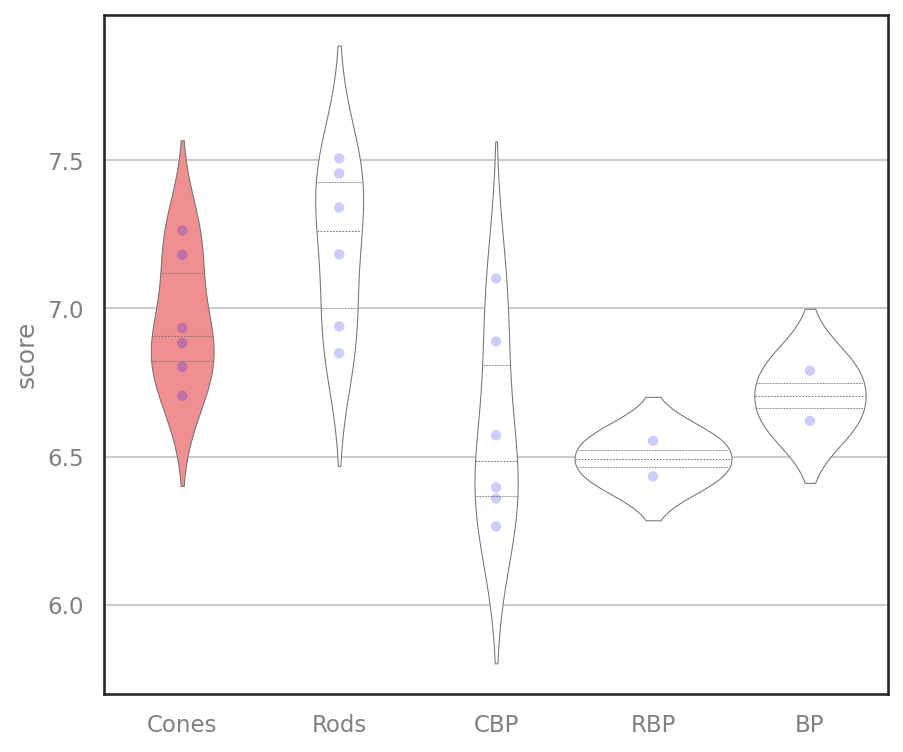

In [130]:
sarin_pdf = PdfPages("sarinPlotsBONE3.pdf")

wwc1_sarin = saveViolin("WWC1",["red","white","white", "white", "white"])
casz1_sarin = saveViolin("CASZ1",["white","red","white", "white", "white"])
ppef2_sarin = saveViolin("PPEF2",["white","red","white", "white", "white"])
akap9_sarin = saveViolin("AKAP9",["red","white","white", "white", "white"])

sarin_pdf.savefig(wwc1_sarin)
sarin_pdf.savefig(casz1_sarin)
sarin_pdf.savefig(ppef2_sarin)
sarin_pdf.savefig(akap9_sarin)
sarin_pdf.close()

### Old Plots

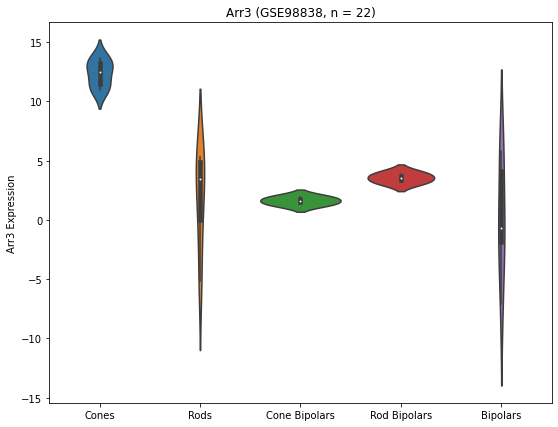

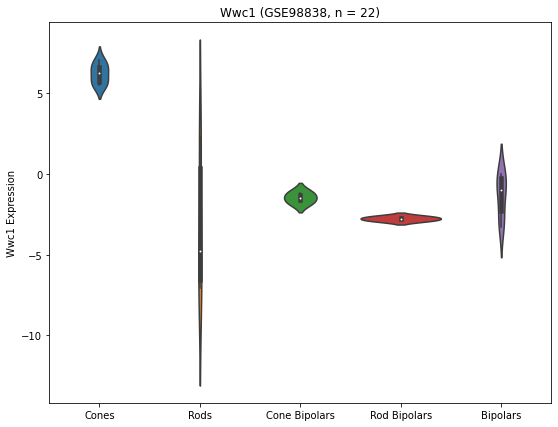

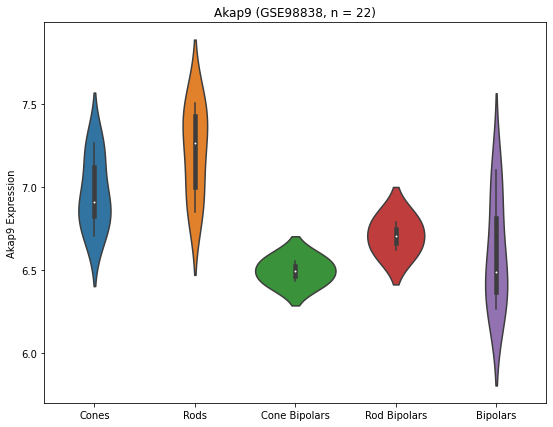

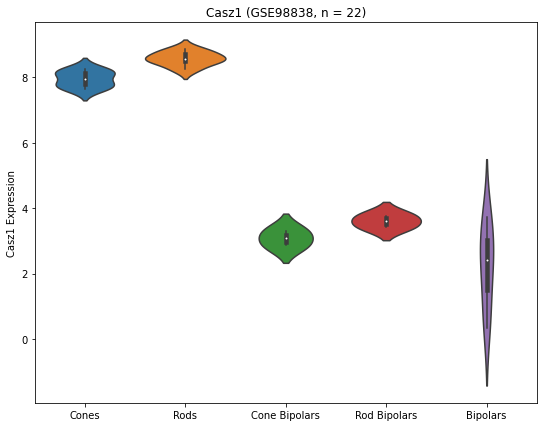

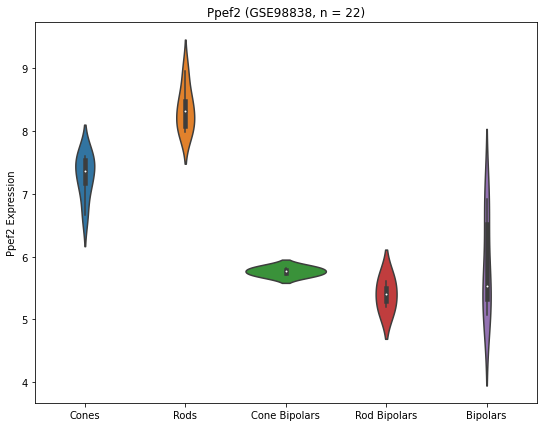

In [100]:
geneViolinplot("Arr3")
geneViolinplot("Wwc1")
geneViolinplot("Akap9")
geneViolinplot("Casz1")
geneViolinplot("Ppef2")

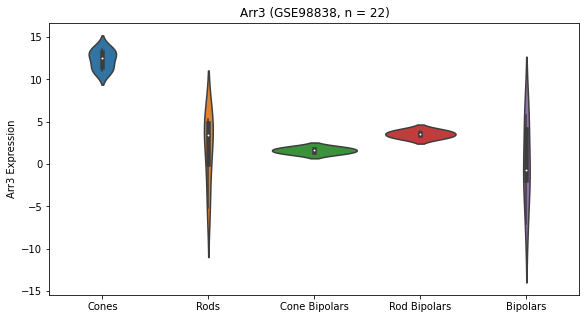

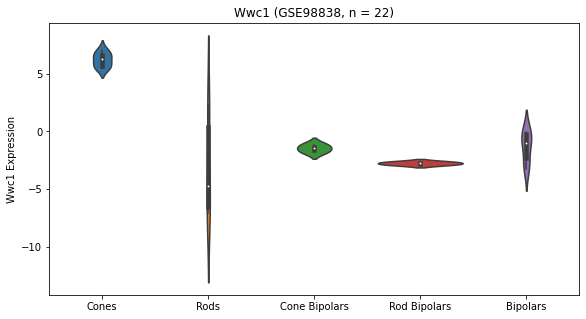

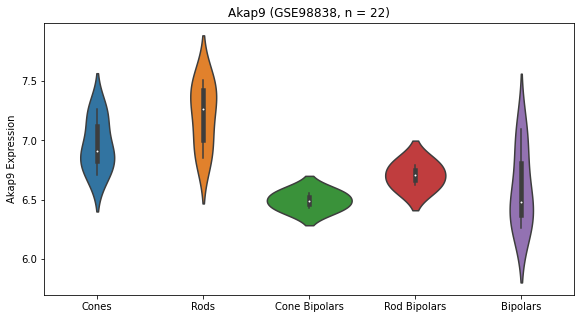

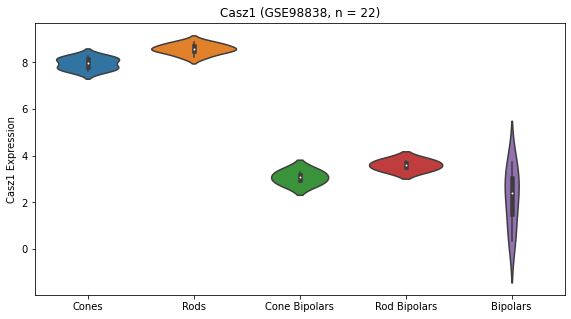

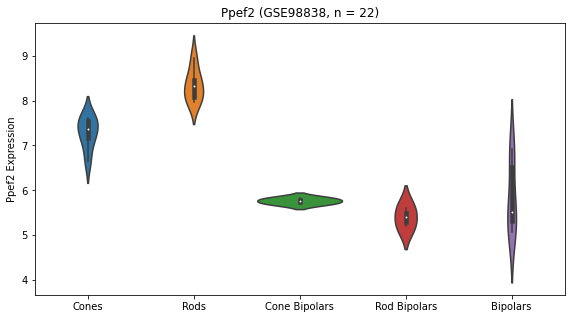

In [34]:
sarin_pdf = PdfPages("sarinPlots.pdf")

arr3_sarin = geneViolinplot("Arr3")
wwc1_sarin = geneViolinplot("Wwc1")
akap9_sarin = geneViolinplot("Akap9")
casz1_sarin = geneViolinplot("Casz1")
ppef2_sarin = geneViolinplot("Ppef2")

sarin_pdf.savefig(arr3_sarin)
sarin_pdf.savefig(wwc1_sarin)
sarin_pdf.savefig(akap9_sarin)
sarin_pdf.savefig(casz1_sarin)
sarin_pdf.savefig(ppef2_sarin)

sarin_pdf.close()

## Voigt Plots

<a id="voigt"></a>

In [72]:
db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
dbid = "RT42"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c cell type")
print(hu.uniq(atype))
cones = [i for i in h.aRange() if atype[i] == 'Cone 3' or atype[i] == 'Cone 4']
rods = [i for i in h.aRange() if atype[i] == 'Rod 1' or atype[i] == 'Rod 2']
bipolar = [i for i in h.aRange() if atype[i] == "Bipolar Cell 1" or atype[i] == "Bipolar Cell 2"]
glial = [i for i in h.aRange() if atype[i] == "Glial Cell 1" or atype[i] == "Glial Cell 2" or atype[i] == "Glial Cell 3" or atype[i] == "Glial Cell 4" or atype[i] == "Glial Cell 5"]
horizontal = [i for i in h.aRange() if atype[i] == 'Horizontal Cell']
endothelial = [i for i in h.aRange() if atype[i] == 'Endothelial Cell'] 
pericyte = [i for i in h.aRange() if atype[i] == 'Pericyte']
ganglion = [i for i in h.aRange() if atype[i] == 'Retinal Ganglion Cell']
amacrine = [i for i in h.aRange() if atype[i] == 'Amacrine Cell']
microglia = [i for i in h.aRange() if atype[i] == 'Microglia']

def geneViolinplot(geneName):
    expr = h.getExprData(geneName)
    expr_cones = np.array([float(expr[i]) for i in cones])
    expr_rods = np.array([float(expr[i]) for i in rods])
    expr_bipolar = np.array([float(expr[i]) for i in bipolar])
    expr_glial = np.array([float(expr[i]) for i in glial])
    expr_horizontal = np.array([float(expr[i]) for i in horizontal])
    expr_endothelial = np.array([float(expr[i]) for i in endothelial])
    expr_pericyte = np.array([float(expr[i]) for i in glial])
    expr_ganglion = np.array([float(expr[i]) for i in ganglion])
    expr_amacrine = np.array([float(expr[i]) for i in amacrine])
    expr_microglia = np.array([float(expr[i]) for i in microglia])
    
    data = [expr_cones, expr_rods, expr_bipolar, expr_glial, expr_horizontal, expr_endothelial, expr_pericyte, \
            expr_ganglion, expr_amacrine, expr_microglia]
    expr_df = pd.DataFrame(data)
    expr_df = expr_df.transpose()
    expr_df.columns = ["Cones", "Rods", "Bipolar", "Glial", "Horizontal", "Endothelial", "Pericyte", "Ganglion", \
                       "Amacrine", "Pericyte"]
    fig, ax = plt.subplots(figsize = (9.5,5))
    ax.set_title(geneName+" (GSE130636, n = 8217)")
    ax.set_ylabel(geneName+" Expression")
    sns.violinplot(ax=ax, data=expr_df.iloc[:,0:9])
    return fig

[8, 'c cell type', 'Unknown', 'Glial Cell 3', 'Cone 3', 'Bipolar Cell 1', 'Horizontal Cell', 'Endothelial Cell', 'Pericyte', 'Glial Cell 5', 'Bipolar Cell 2', 'Rod 1', 'Retinal Ganglion Cell', 'Rod 2', 'Glial Cell 4', 'Amacrine Cell', 'Microglia', 'Glial Cell 2', 'Glial Cell 1', 'Cone 4']


In [73]:
def makeDF(geneName):
    expr = h.getExprData(geneName)
    expr_cones = np.array([float(expr[i]) for i in cones])
    expr_rods = np.array([float(expr[i]) for i in rods])
    expr_bipolar = np.array([float(expr[i]) for i in bipolar])
    expr_glial = np.array([float(expr[i]) for i in glial])
    expr_horizontal = np.array([float(expr[i]) for i in horizontal])
    expr_endothelial = np.array([float(expr[i]) for i in endothelial])
    expr_pericyte = np.array([float(expr[i]) for i in glial])
    expr_ganglion = np.array([float(expr[i]) for i in ganglion])
    expr_amacrine = np.array([float(expr[i]) for i in amacrine])
    expr_microglia = np.array([float(expr[i]) for i in microglia])
    
    data = [expr_cones, expr_rods, expr_bipolar, expr_glial, expr_horizontal, expr_endothelial, expr_pericyte, \
            expr_ganglion, expr_amacrine, expr_microglia]
    expr_df = pd.DataFrame(data)
    expr_df = expr_df.transpose()
    print(expr_df)
    return(expr_df)

def saveViolin(geneName, acolor):
    arr3 = makeDF(geneName)
    params = {"dpi":150, "w":4.25*5, "h":3.25*5, "acolor":["red","white","white", "white", "white"]}
    atypes = ["Cones", "Rods", "Bipolar", "Glial", "Horizontal", "Endothelial", "Pericyte", "Ganglion",\
          "Amacrine", "Pericyte"]
    arr3_plot = plotViolin3(arr3, 10, atypes, params)
    return(arr3_plot)

In [68]:
%run /Users/rohan/public_html/Hegemon/bone.py

<Figure size 432x288 with 0 Axes>

### New Plots

             0    1    2    3    4    5    6    7    8    9
0     1.862177  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     2.348057  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     3.552438  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4     0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2408       NaN  NaN  NaN  0.0  NaN  NaN  0.0  NaN  NaN  NaN
2409       NaN  NaN  NaN  0.0  NaN  NaN  0.0  NaN  NaN  NaN
2410       NaN  NaN  NaN  0.0  NaN  NaN  0.0  NaN  NaN  NaN
2411       NaN  NaN  NaN  0.0  NaN  NaN  0.0  NaN  NaN  NaN
2412       NaN  NaN  NaN  0.0  NaN  NaN  0.0  NaN  NaN  NaN

[2413 rows x 10 columns]


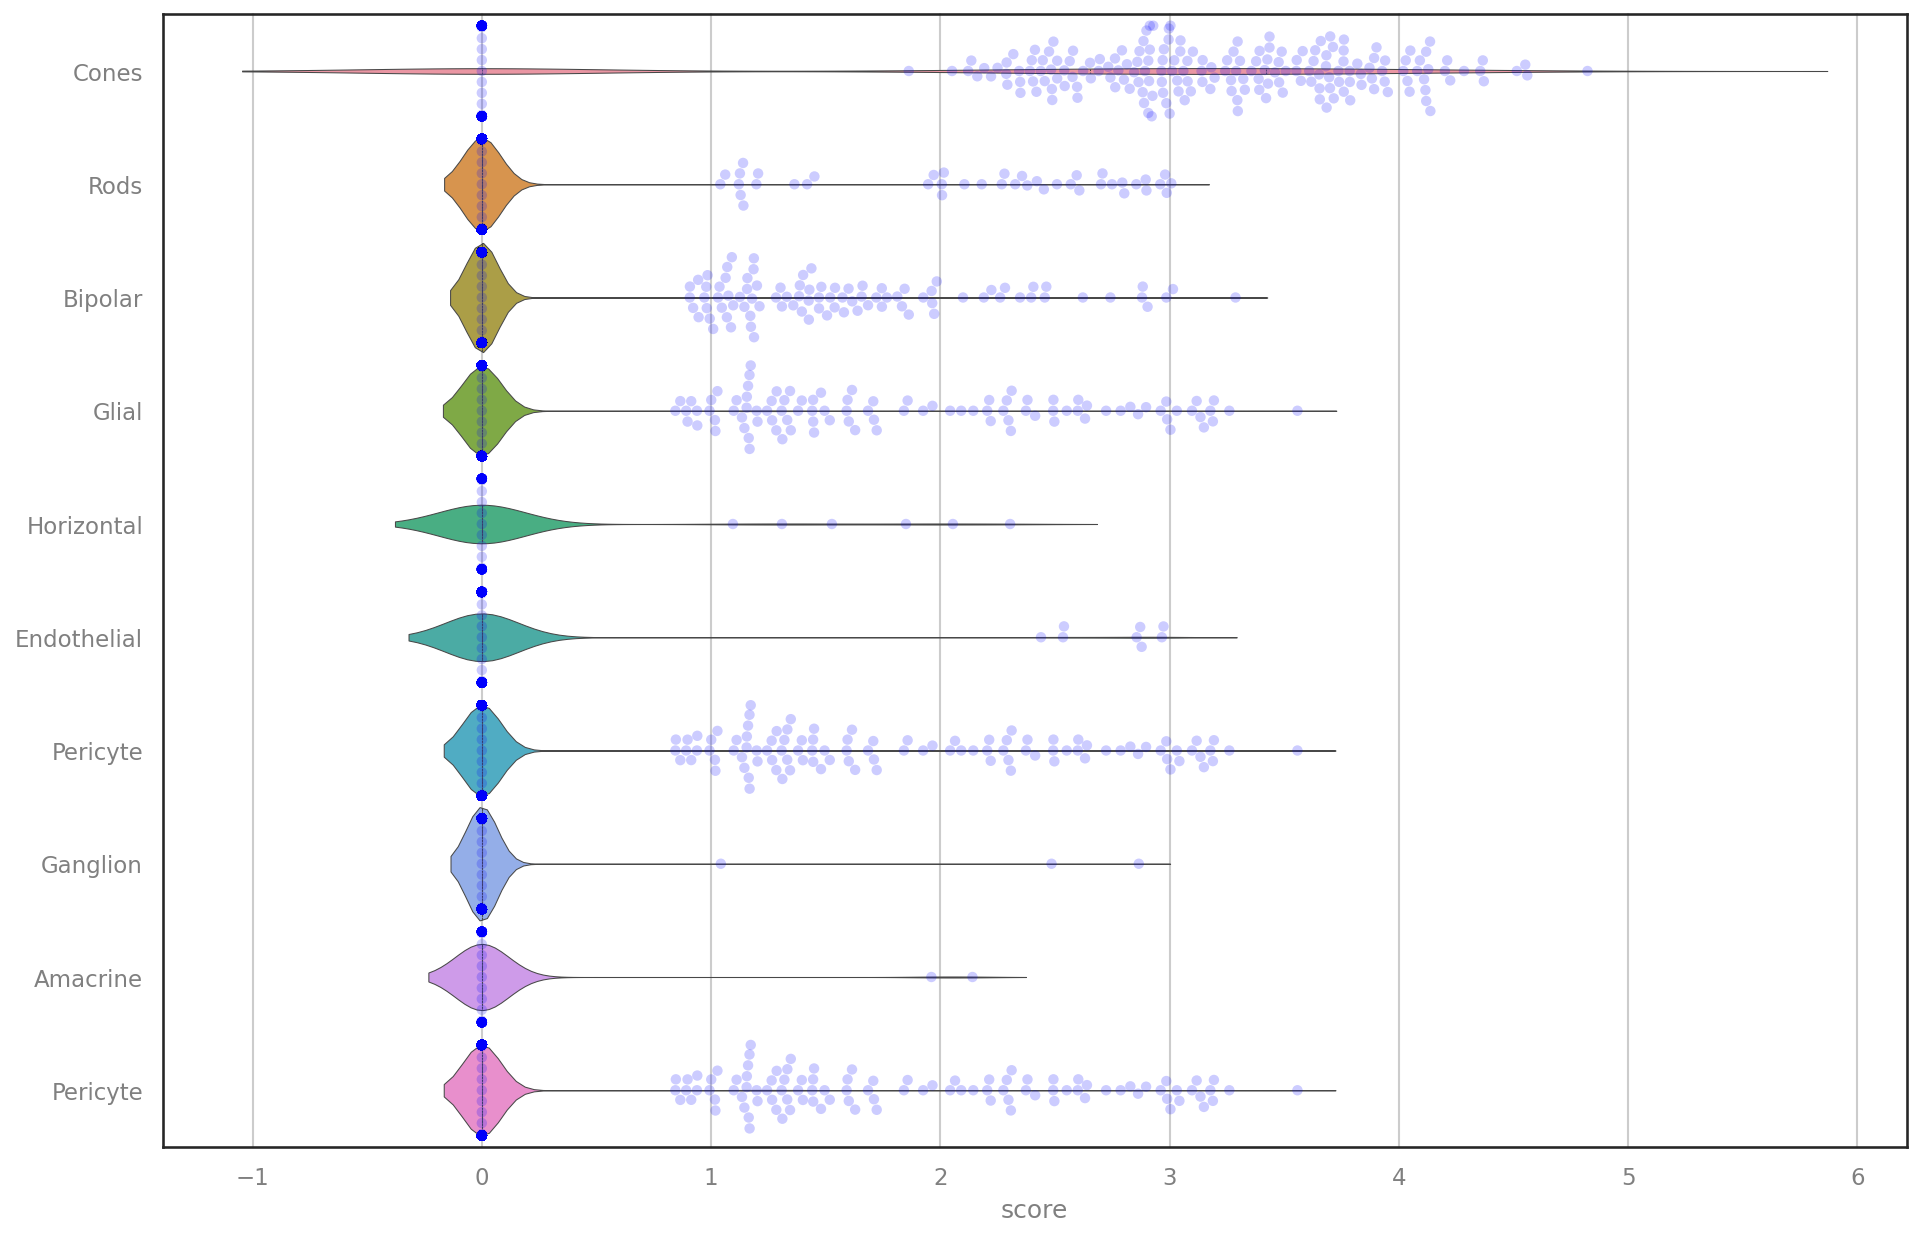

In [61]:
arr3 = makeDF("ARR3")
params = {"dpi":150, "w":3*5, "h":2*5, "acolor":["red","white","white", "white", "white"]}
atypes = ["Cones", "Rods", "Bipolar", "Glial", "Horizontal", "Endothelial", "Pericyte", "Ganglion",\
          "Amacrine", "Pericyte"]
arr3_plot = plotViolin3(arr3, 10, atypes, params)

             0    1    2    3    4    5    6    7    8    9
0     1.862177  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     2.348057  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     3.552438  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4     0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2408       NaN  NaN  NaN  0.0  NaN  NaN  0.0  NaN  NaN  NaN
2409       NaN  NaN  NaN  0.0  NaN  NaN  0.0  NaN  NaN  NaN
2410       NaN  NaN  NaN  0.0  NaN  NaN  0.0  NaN  NaN  NaN
2411       NaN  NaN  NaN  0.0  NaN  NaN  0.0  NaN  NaN  NaN
2412       NaN  NaN  NaN  0.0  NaN  NaN  0.0  NaN  NaN  NaN

[2413 rows x 10 columns]


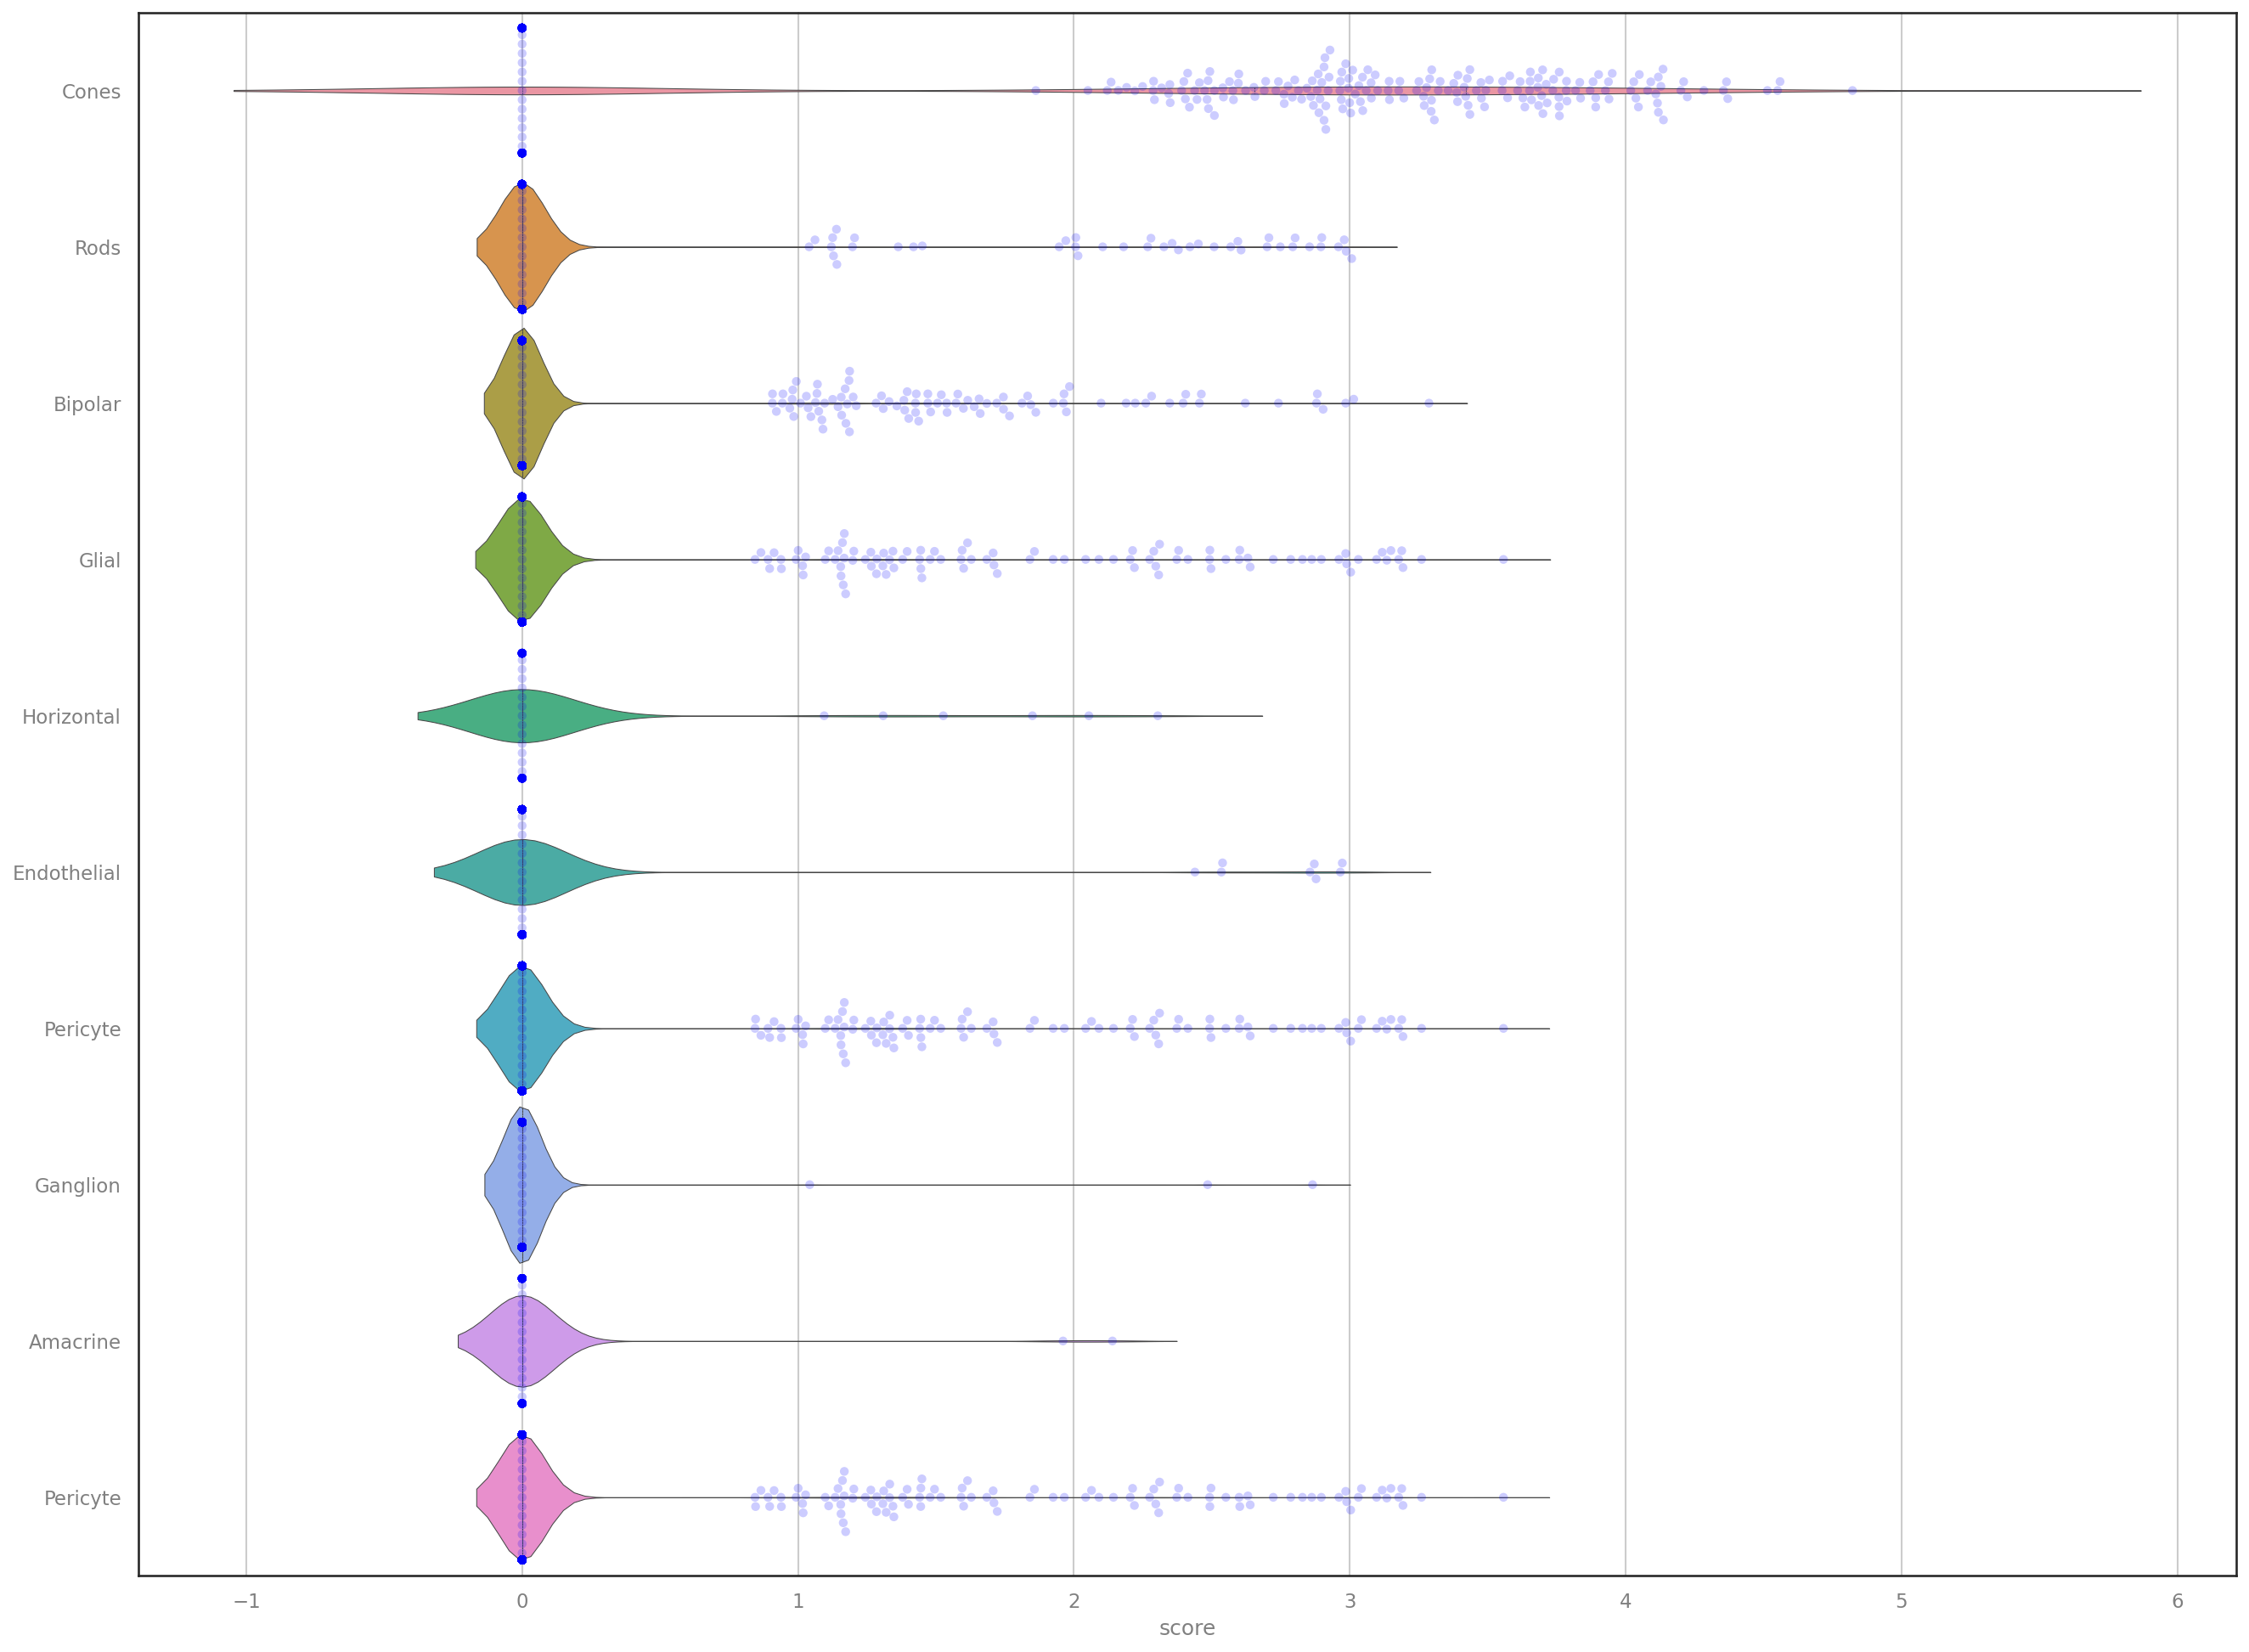

In [75]:
arr3 = makeDF("ARR3")
params = {"dpi":150, "w":4.25*5, "h":3.25*5, "acolor":["red","white","white", "white", "white"]}
atypes = ["Cones", "Rods", "Bipolar", "Glial", "Horizontal", "Endothelial", "Pericyte", "Ganglion",\
          "Amacrine", "Pericyte"]
arr3_plot = plotViolin3(arr3, 10, atypes, params)

             0    1    2         3    4    5         6    7    8    9
0     2.474475  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0
1     0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0
2     0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0
3     0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0
4     0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0
...        ...  ...  ...       ...  ...  ...       ...  ...  ...  ...
2408       NaN  NaN  NaN  0.000000  NaN  NaN  0.000000  NaN  NaN  NaN
2409       NaN  NaN  NaN  0.000000  NaN  NaN  0.000000  NaN  NaN  NaN
2410       NaN  NaN  NaN  0.000000  NaN  NaN  0.000000  NaN  NaN  NaN
2411       NaN  NaN  NaN  2.058039  NaN  NaN  2.058039  NaN  NaN  NaN
2412       NaN  NaN  NaN  0.000000  NaN  NaN  0.000000  NaN  NaN  NaN

[2413 rows x 10 columns]
             0    1    2         3    4    5         6    7    8    9
0     1.862177  0.0  0.0  1.443677  0.0  0.0  1.443677  0.0  0.0

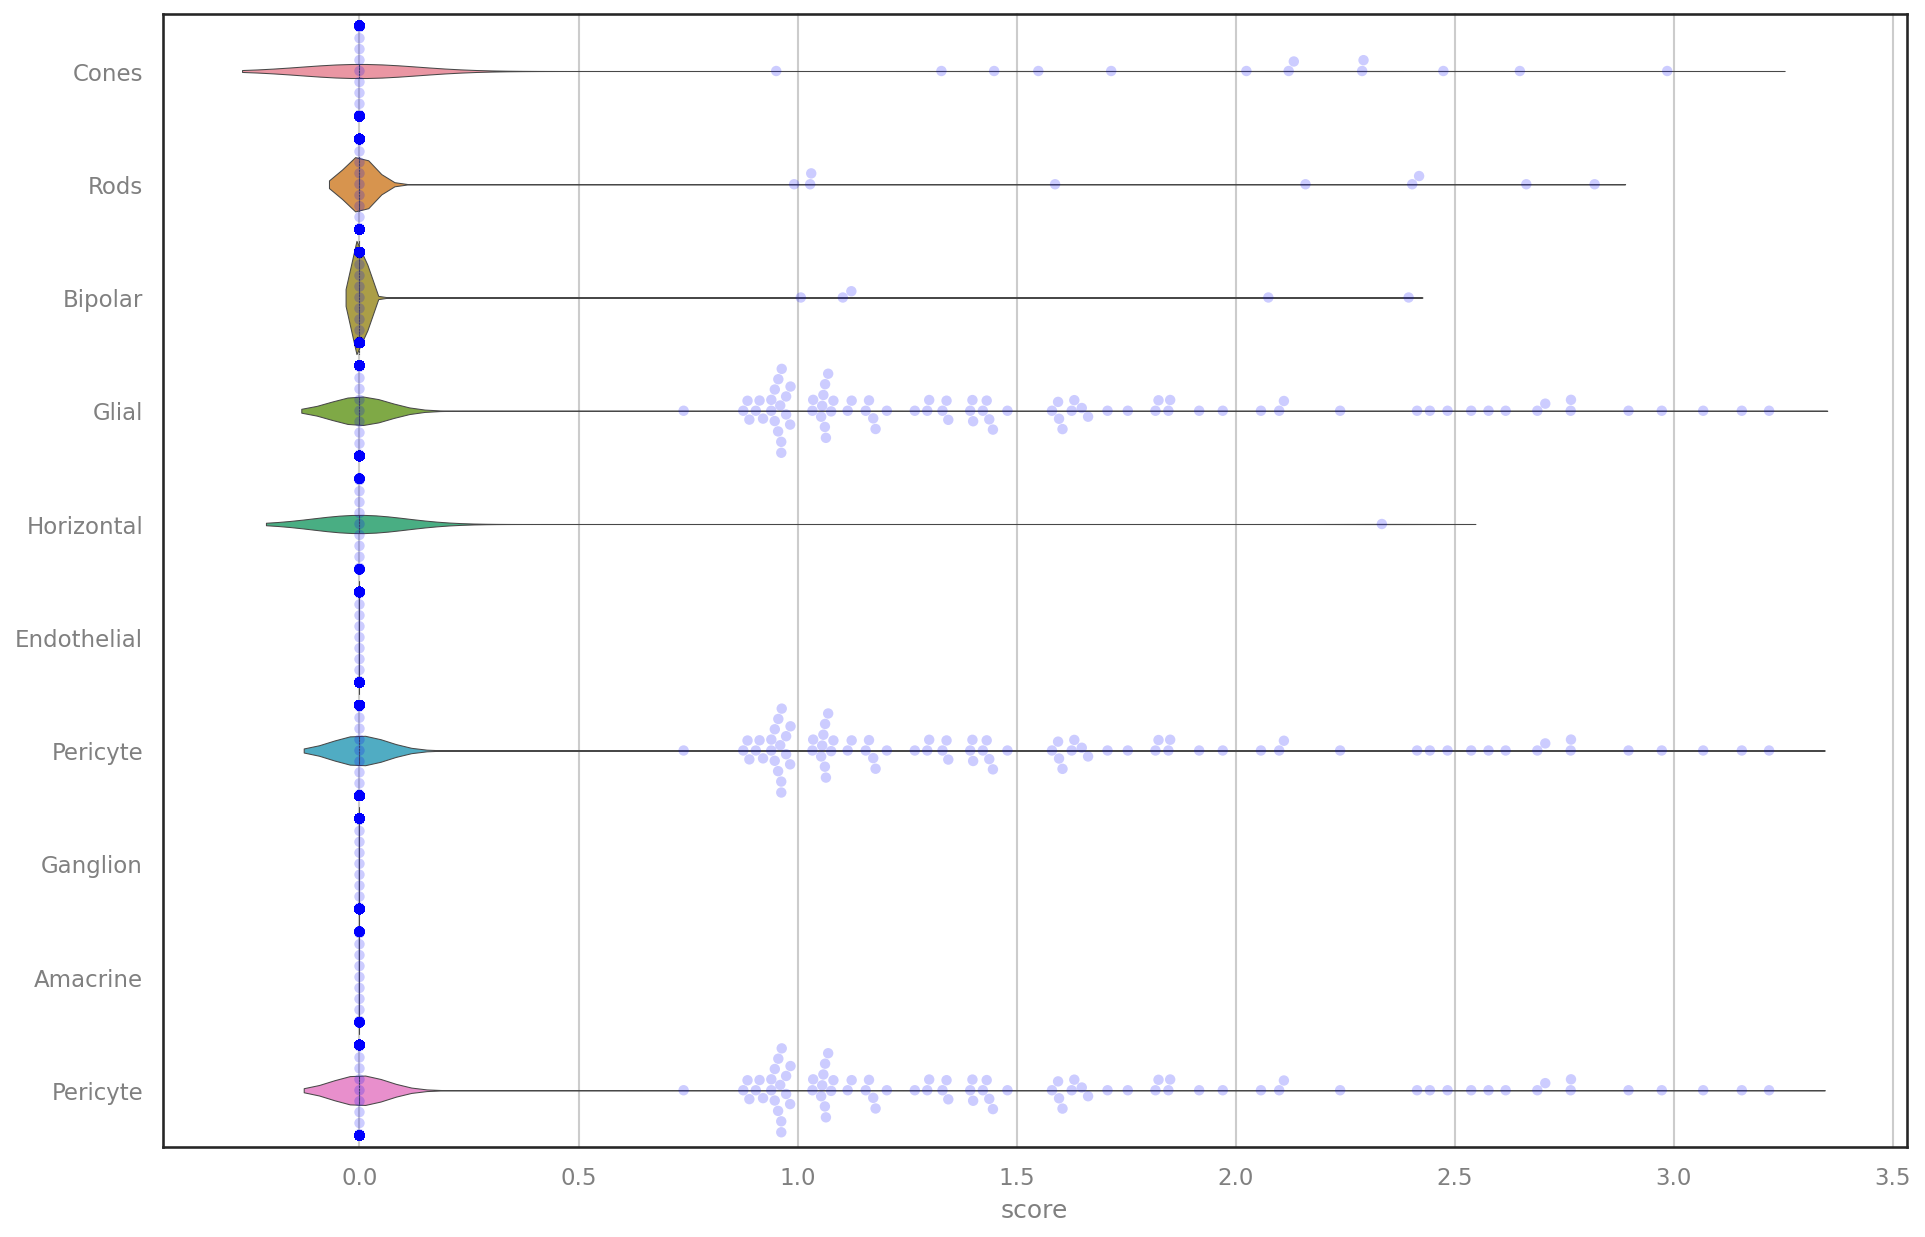

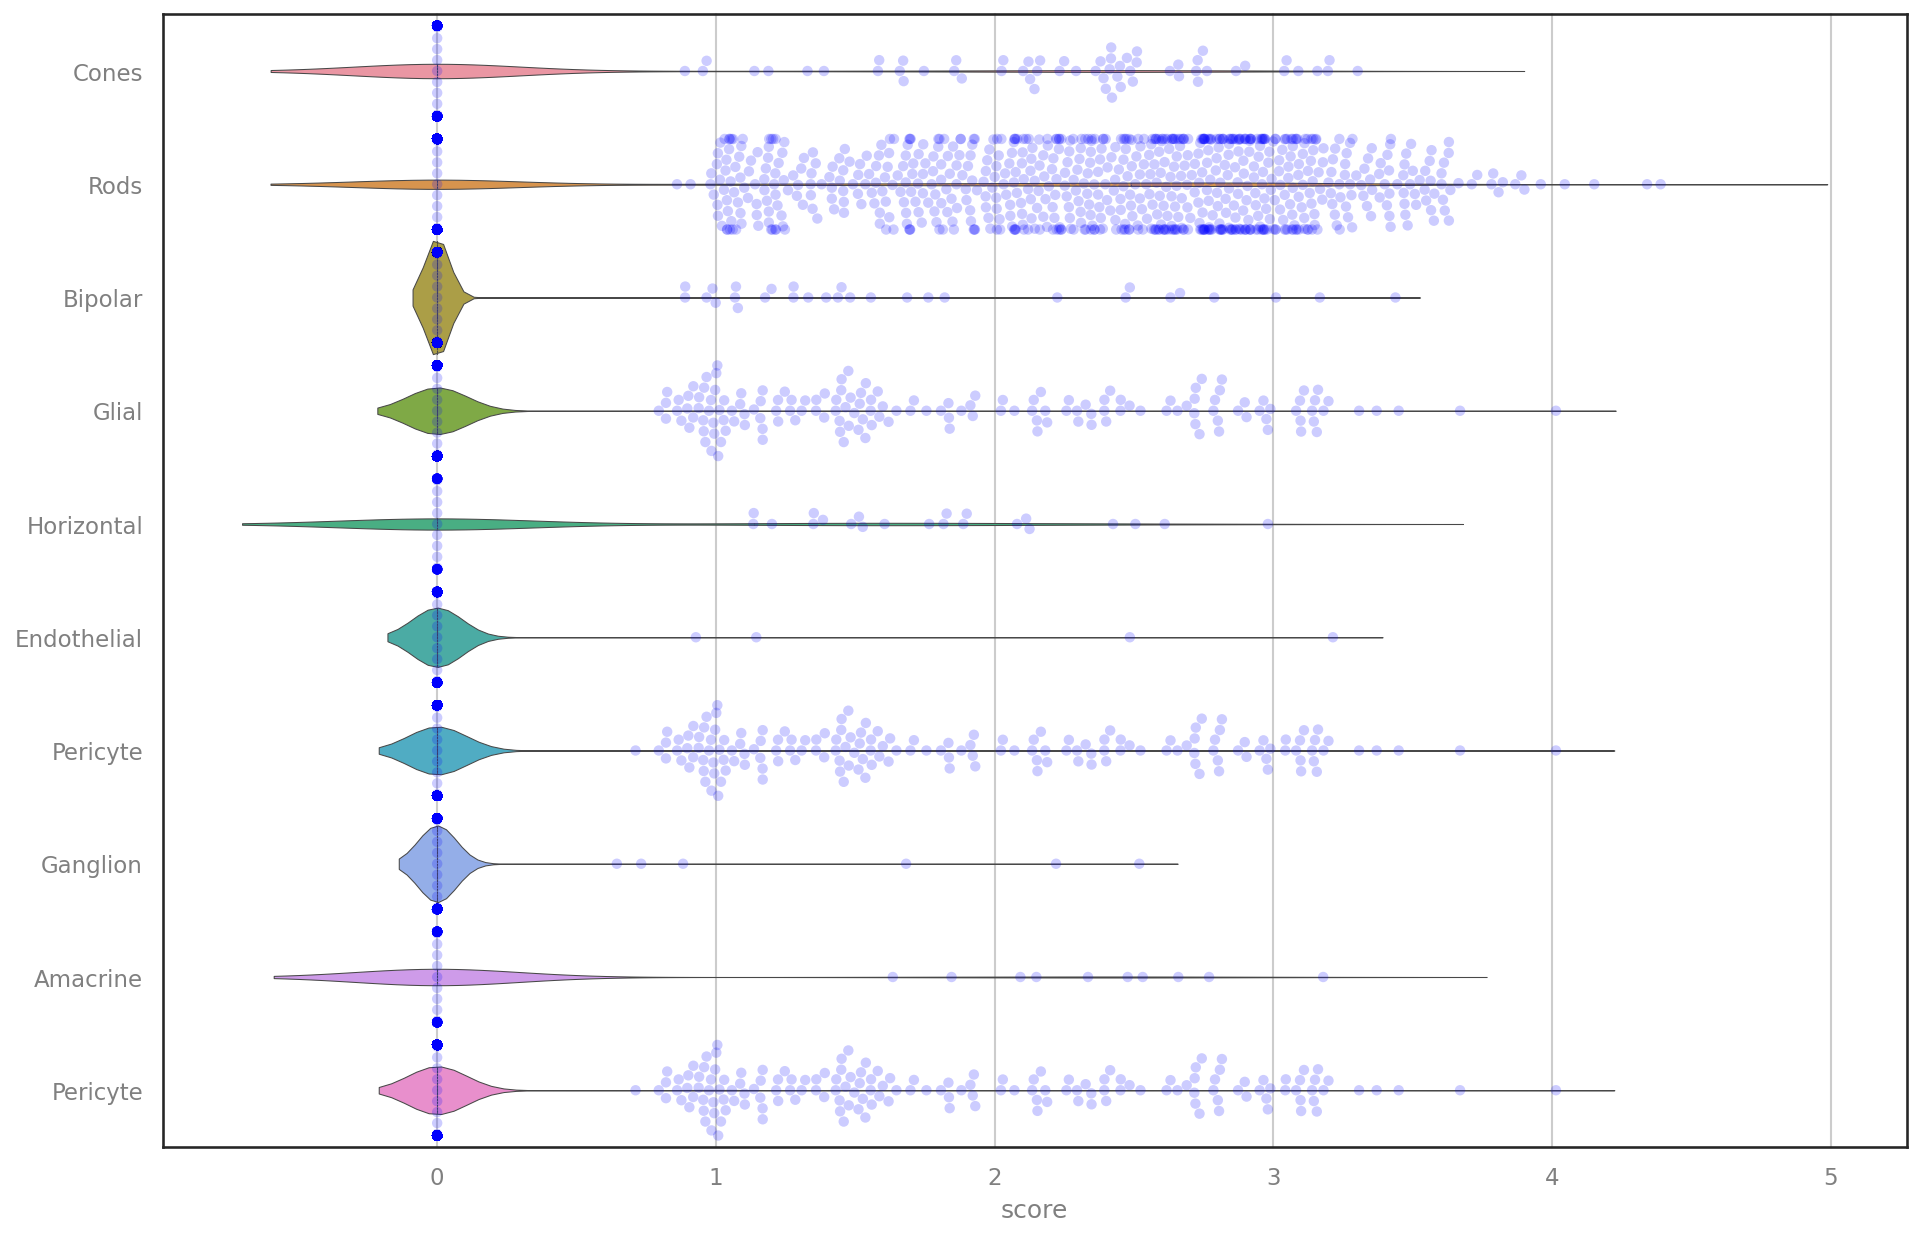

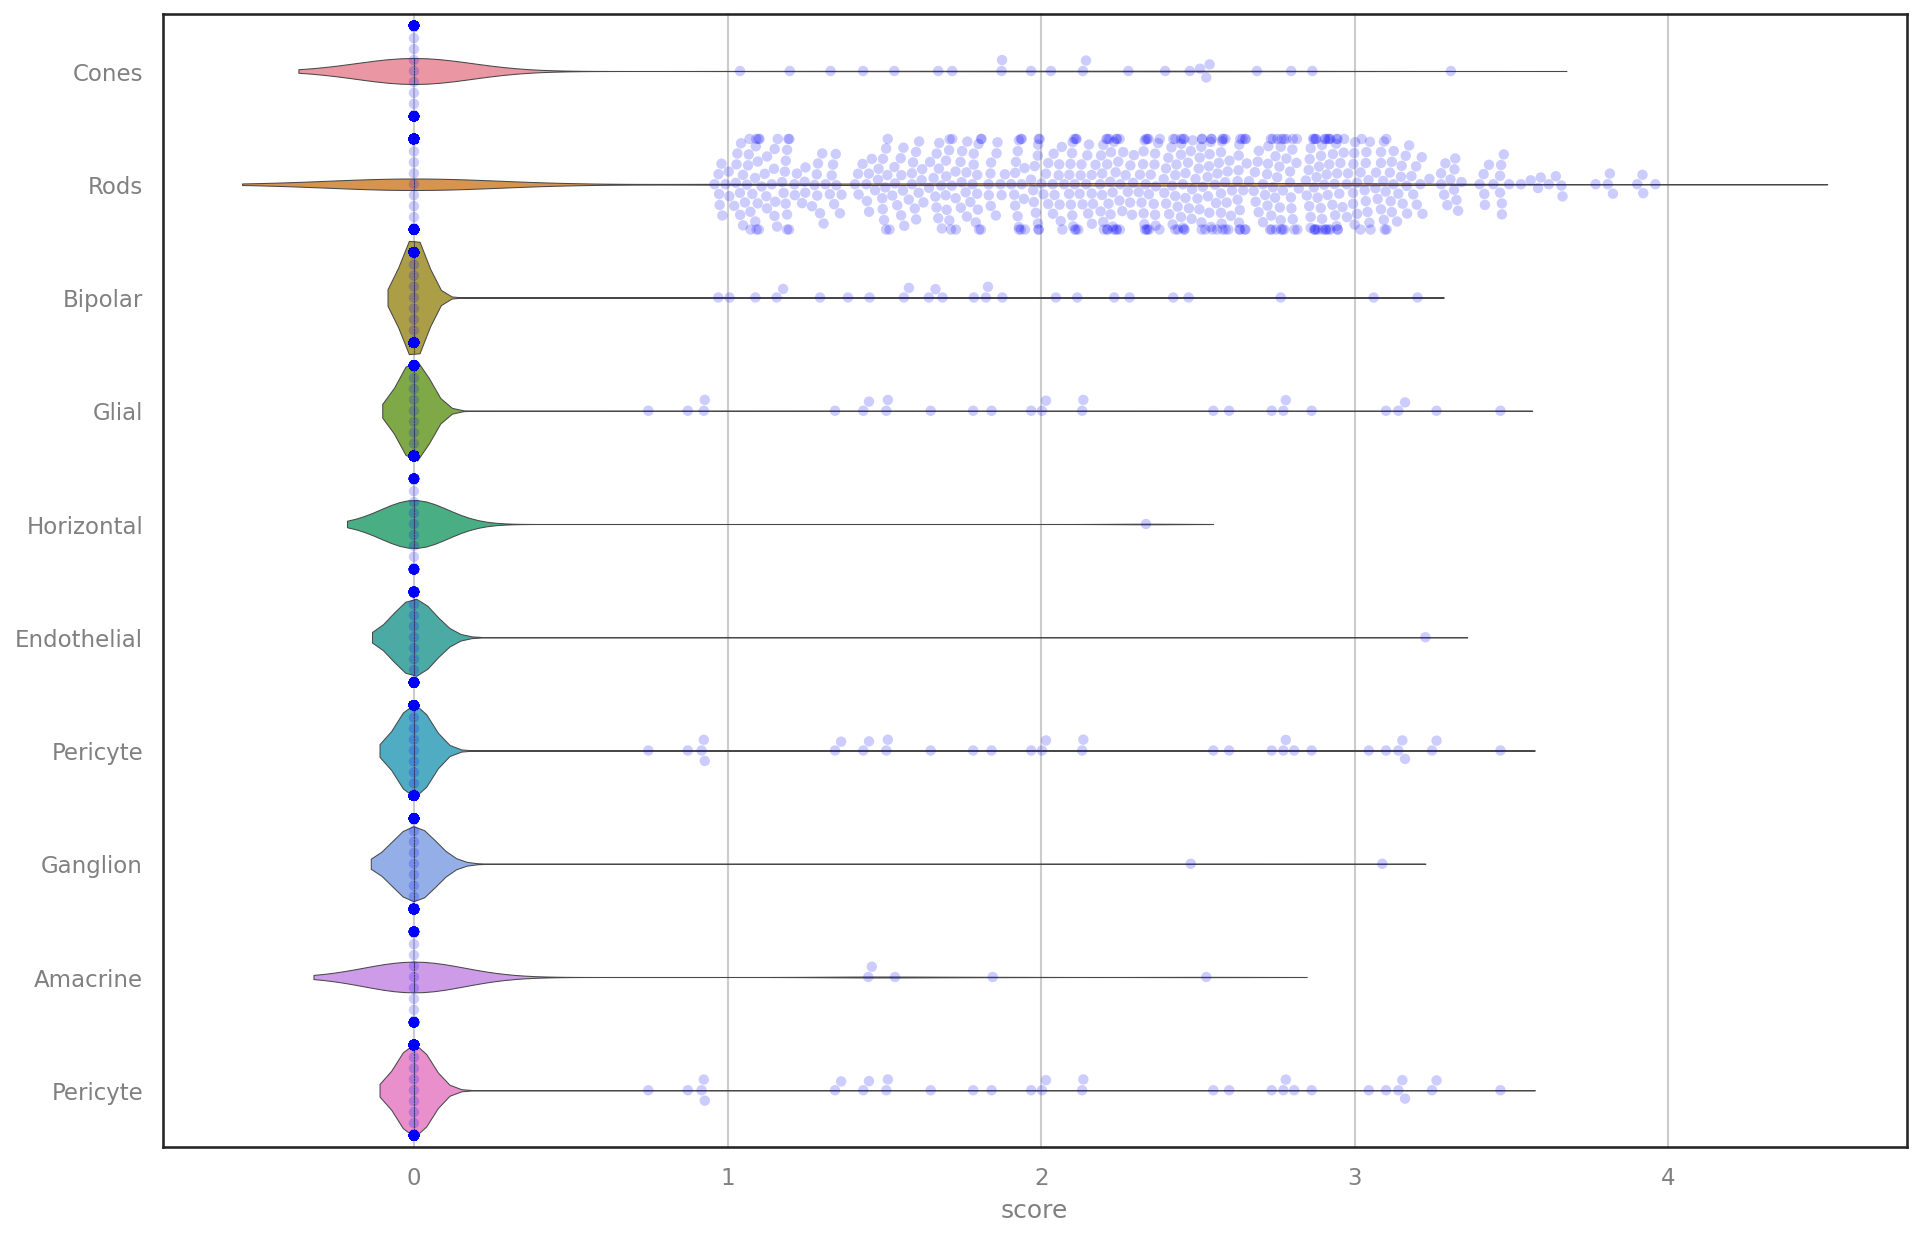

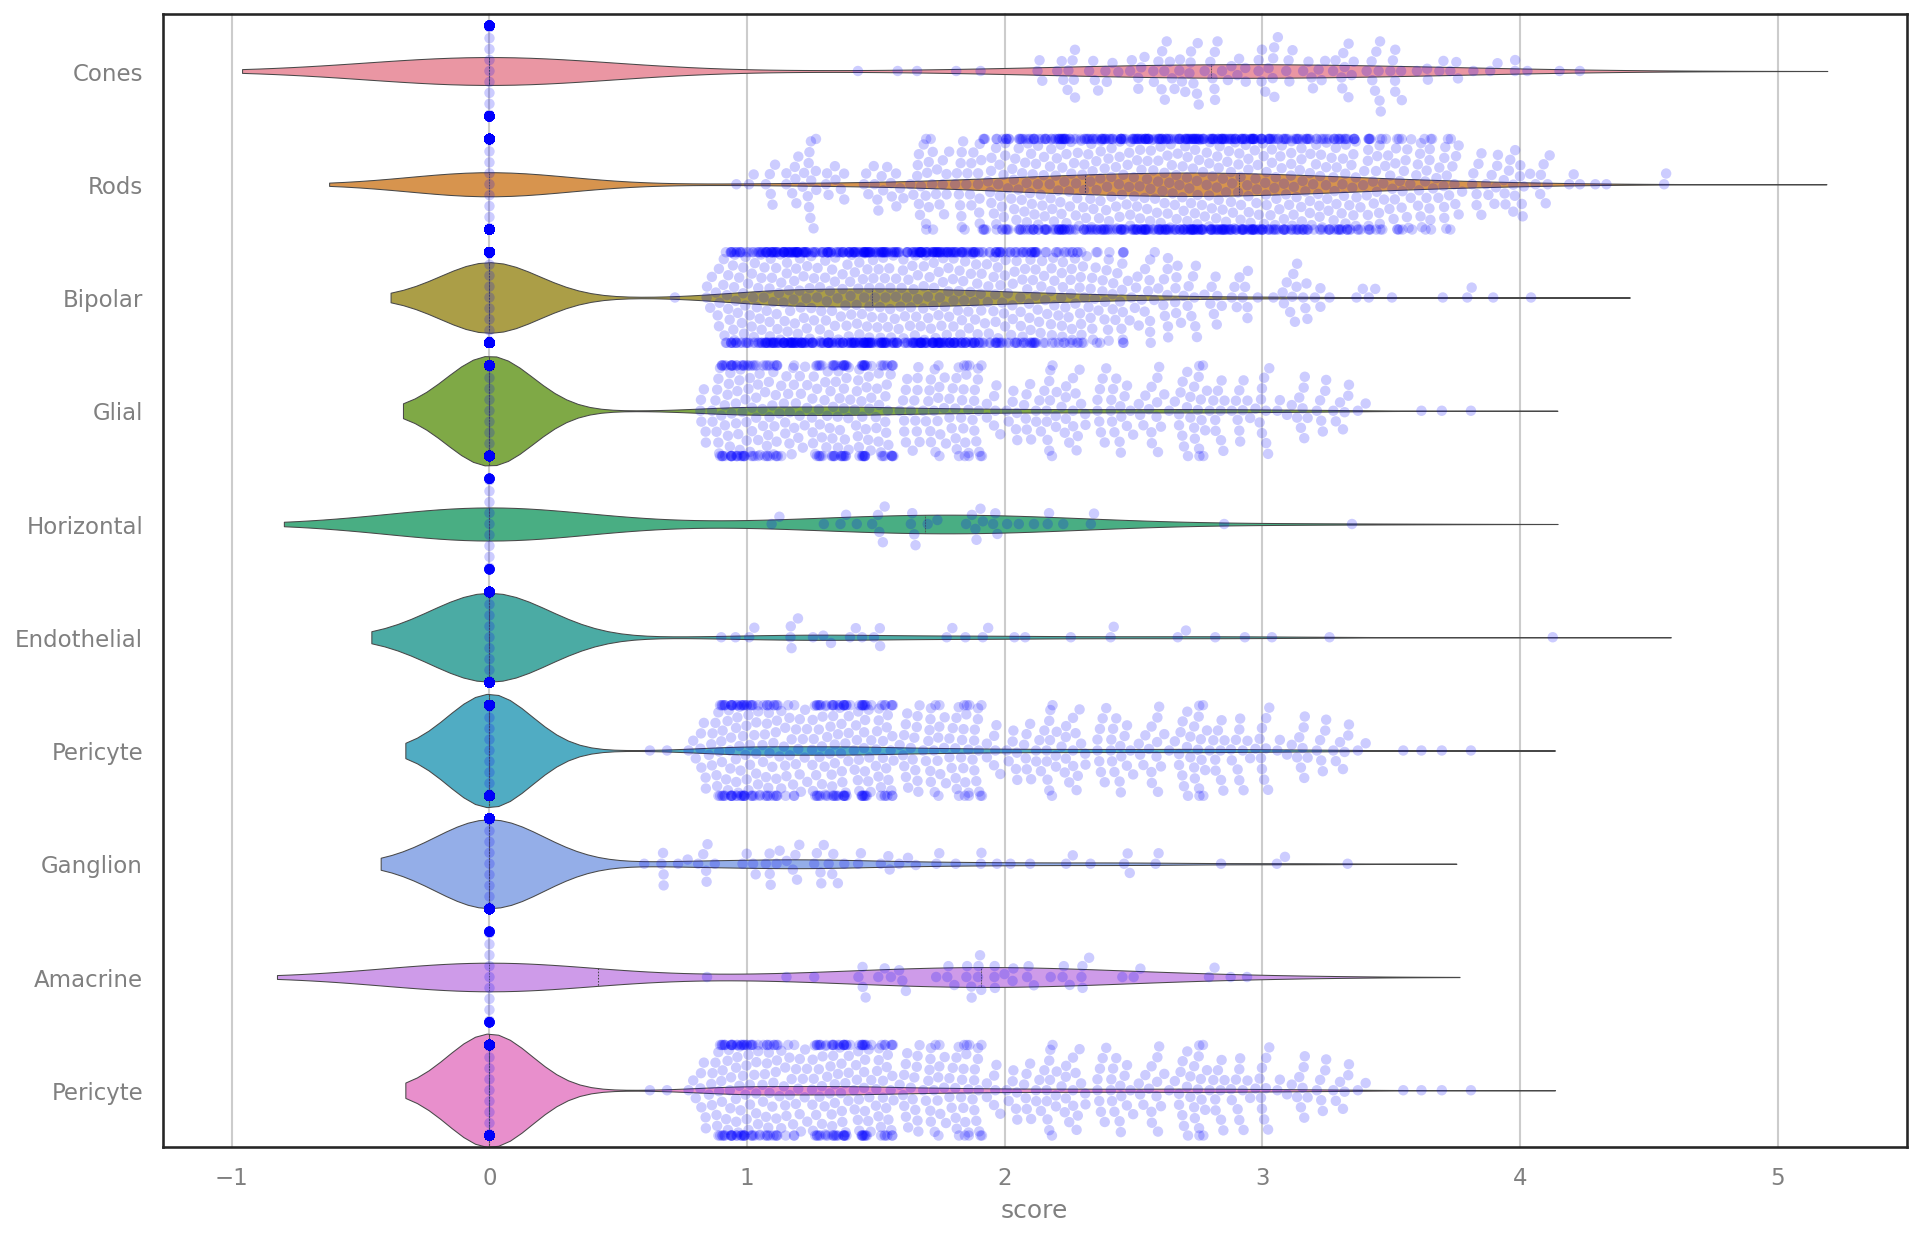

In [65]:
voigt_pdf = PdfPages("voigtPlotsBONE2.pdf")

wwc1_sarin = saveViolin("WWC1",["red","white","white", "white", "white"])
casz1_sarin = saveViolin("CASZ1",["white","red","white", "white", "white"])
ppef2_sarin = saveViolin("PPEF2",["white","red","white", "white", "white"])
akap9_sarin = saveViolin("AKAP9",["red","white","white", "white", "white"])

voigt_pdf.savefig(wwc1_sarin)
voigt_pdf.savefig(casz1_sarin)
voigt_pdf.savefig(ppef2_sarin)
voigt_pdf.savefig(akap9_sarin)
voigt_pdf.close()

             0    1    2         3    4    5         6    7    8    9
0     2.474475  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0
1     0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0
2     0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0
3     0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0
4     0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0
...        ...  ...  ...       ...  ...  ...       ...  ...  ...  ...
2408       NaN  NaN  NaN  0.000000  NaN  NaN  0.000000  NaN  NaN  NaN
2409       NaN  NaN  NaN  0.000000  NaN  NaN  0.000000  NaN  NaN  NaN
2410       NaN  NaN  NaN  0.000000  NaN  NaN  0.000000  NaN  NaN  NaN
2411       NaN  NaN  NaN  2.058039  NaN  NaN  2.058039  NaN  NaN  NaN
2412       NaN  NaN  NaN  0.000000  NaN  NaN  0.000000  NaN  NaN  NaN

[2413 rows x 10 columns]
             0    1    2         3    4    5         6    7    8    9
0     1.862177  0.0  0.0  1.443677  0.0  0.0  1.443677  0.0  0.0

KeyboardInterrupt: 

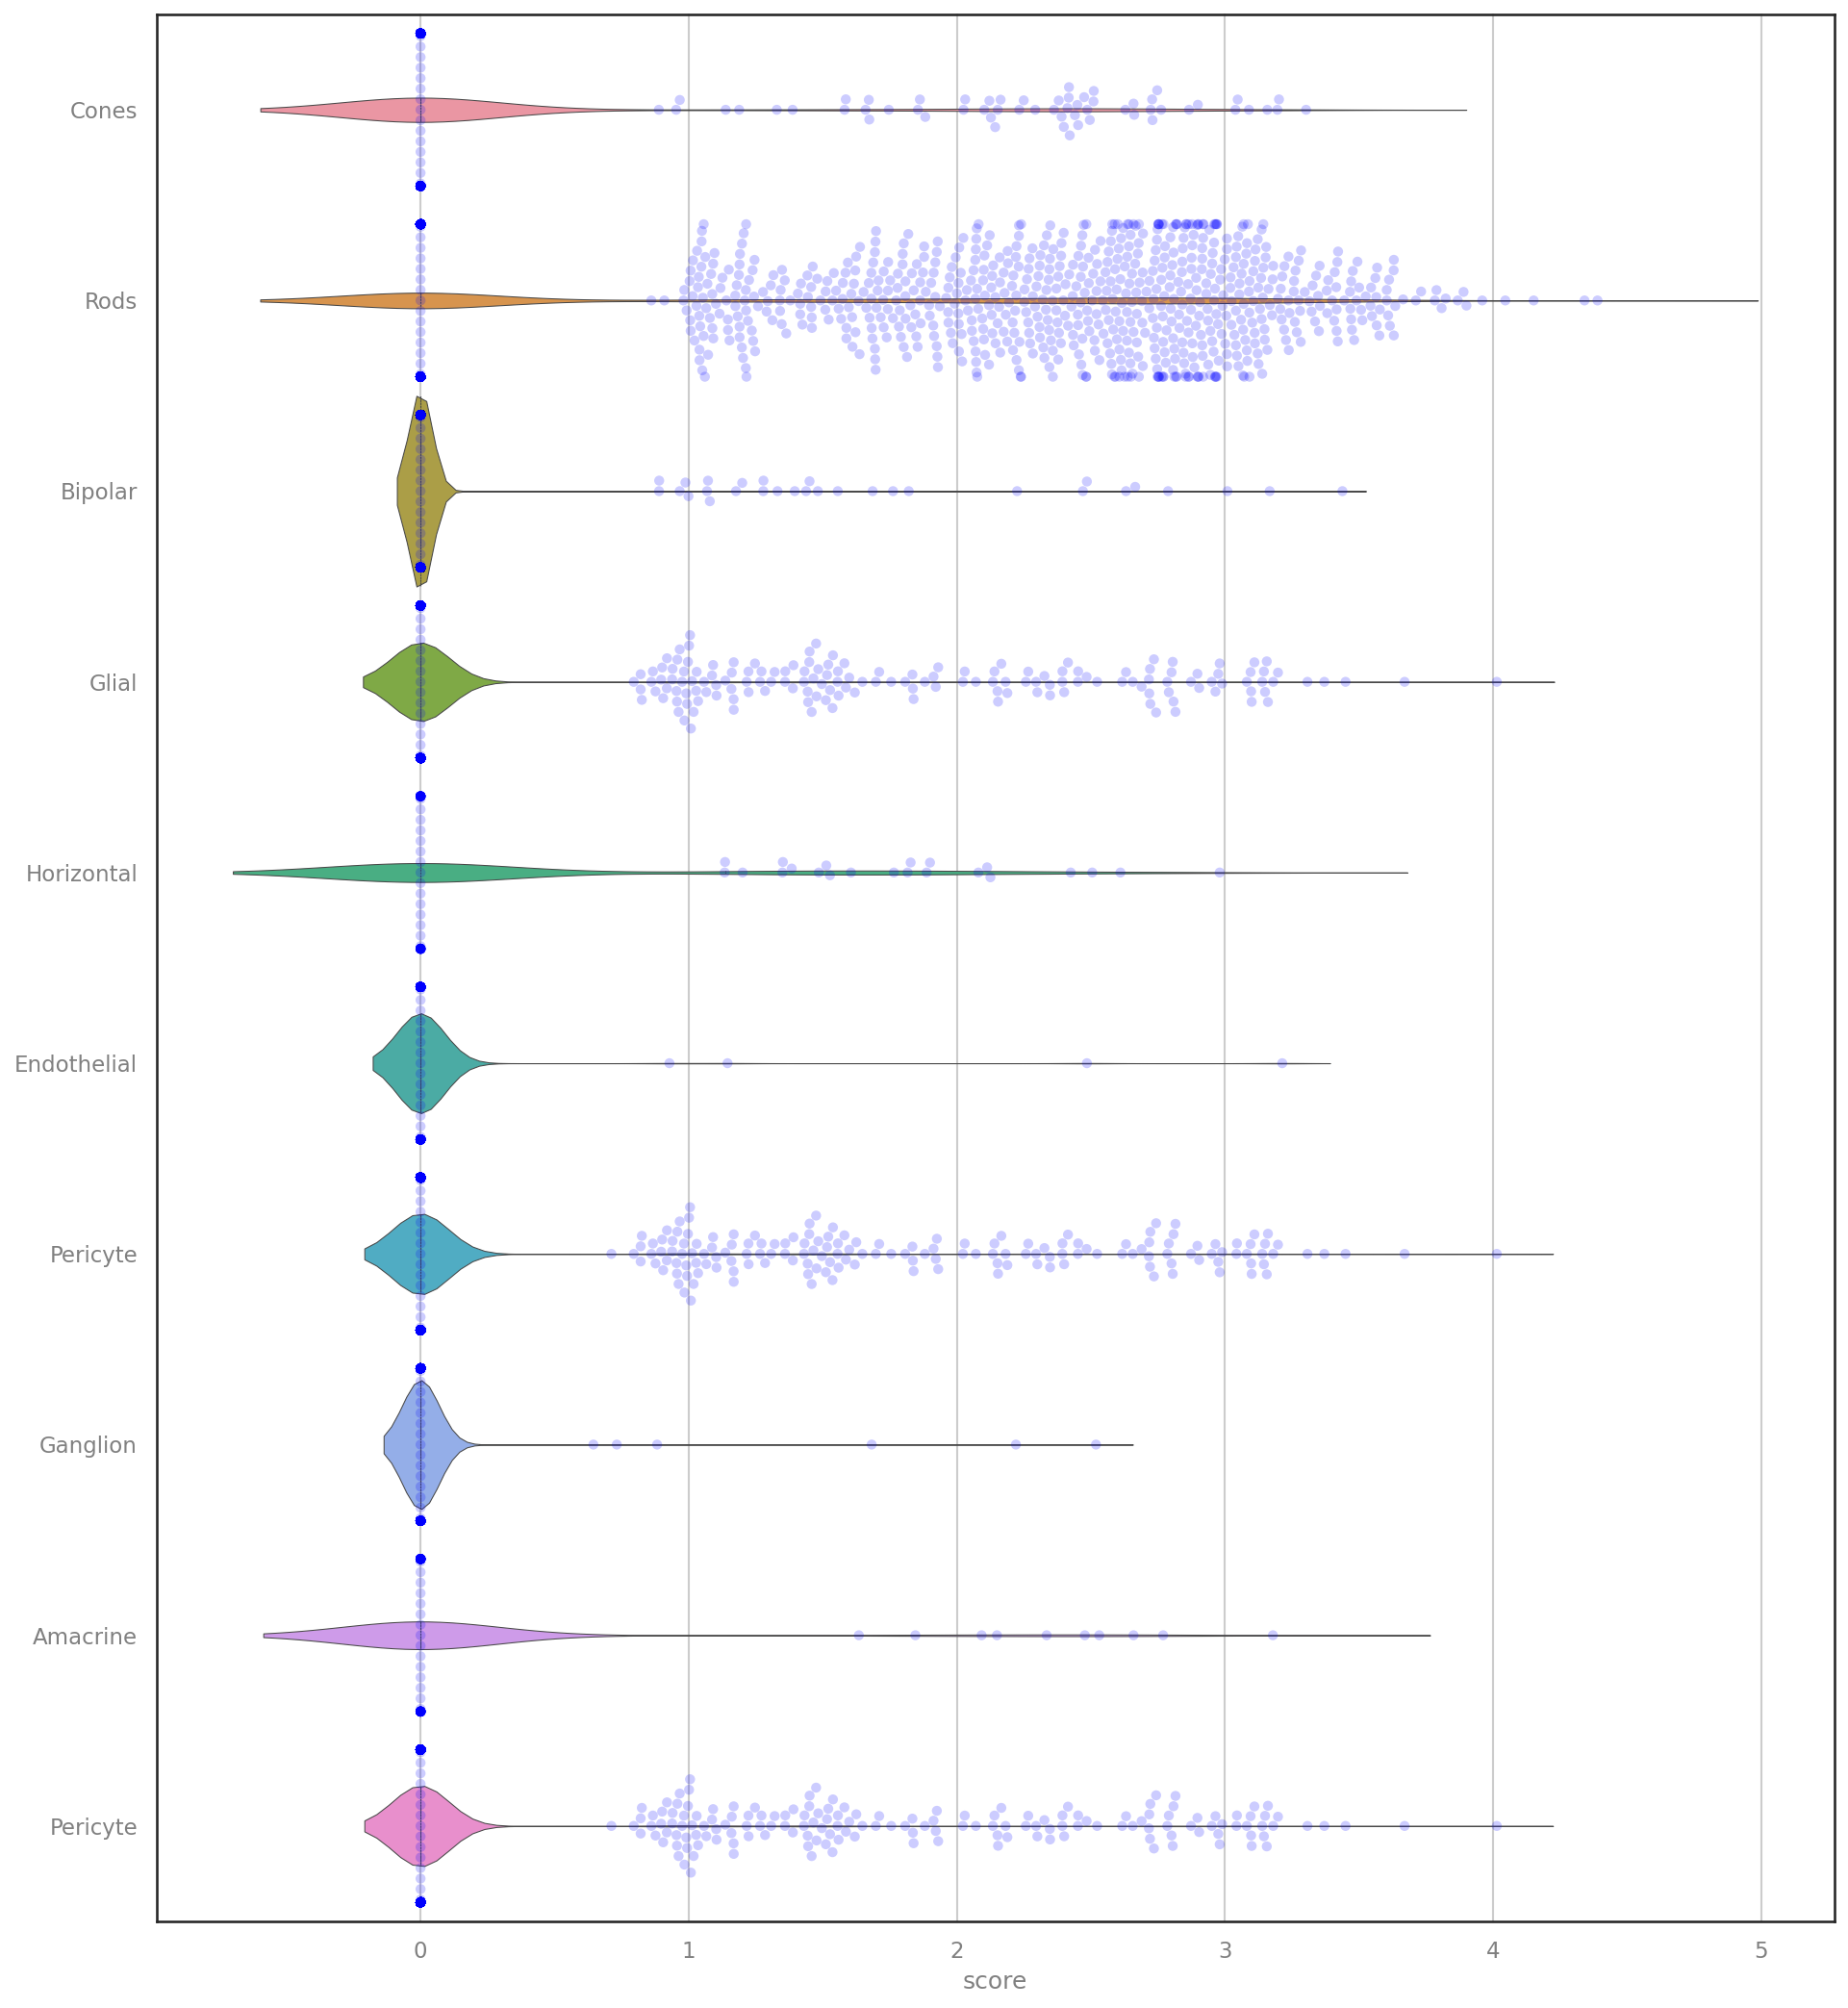

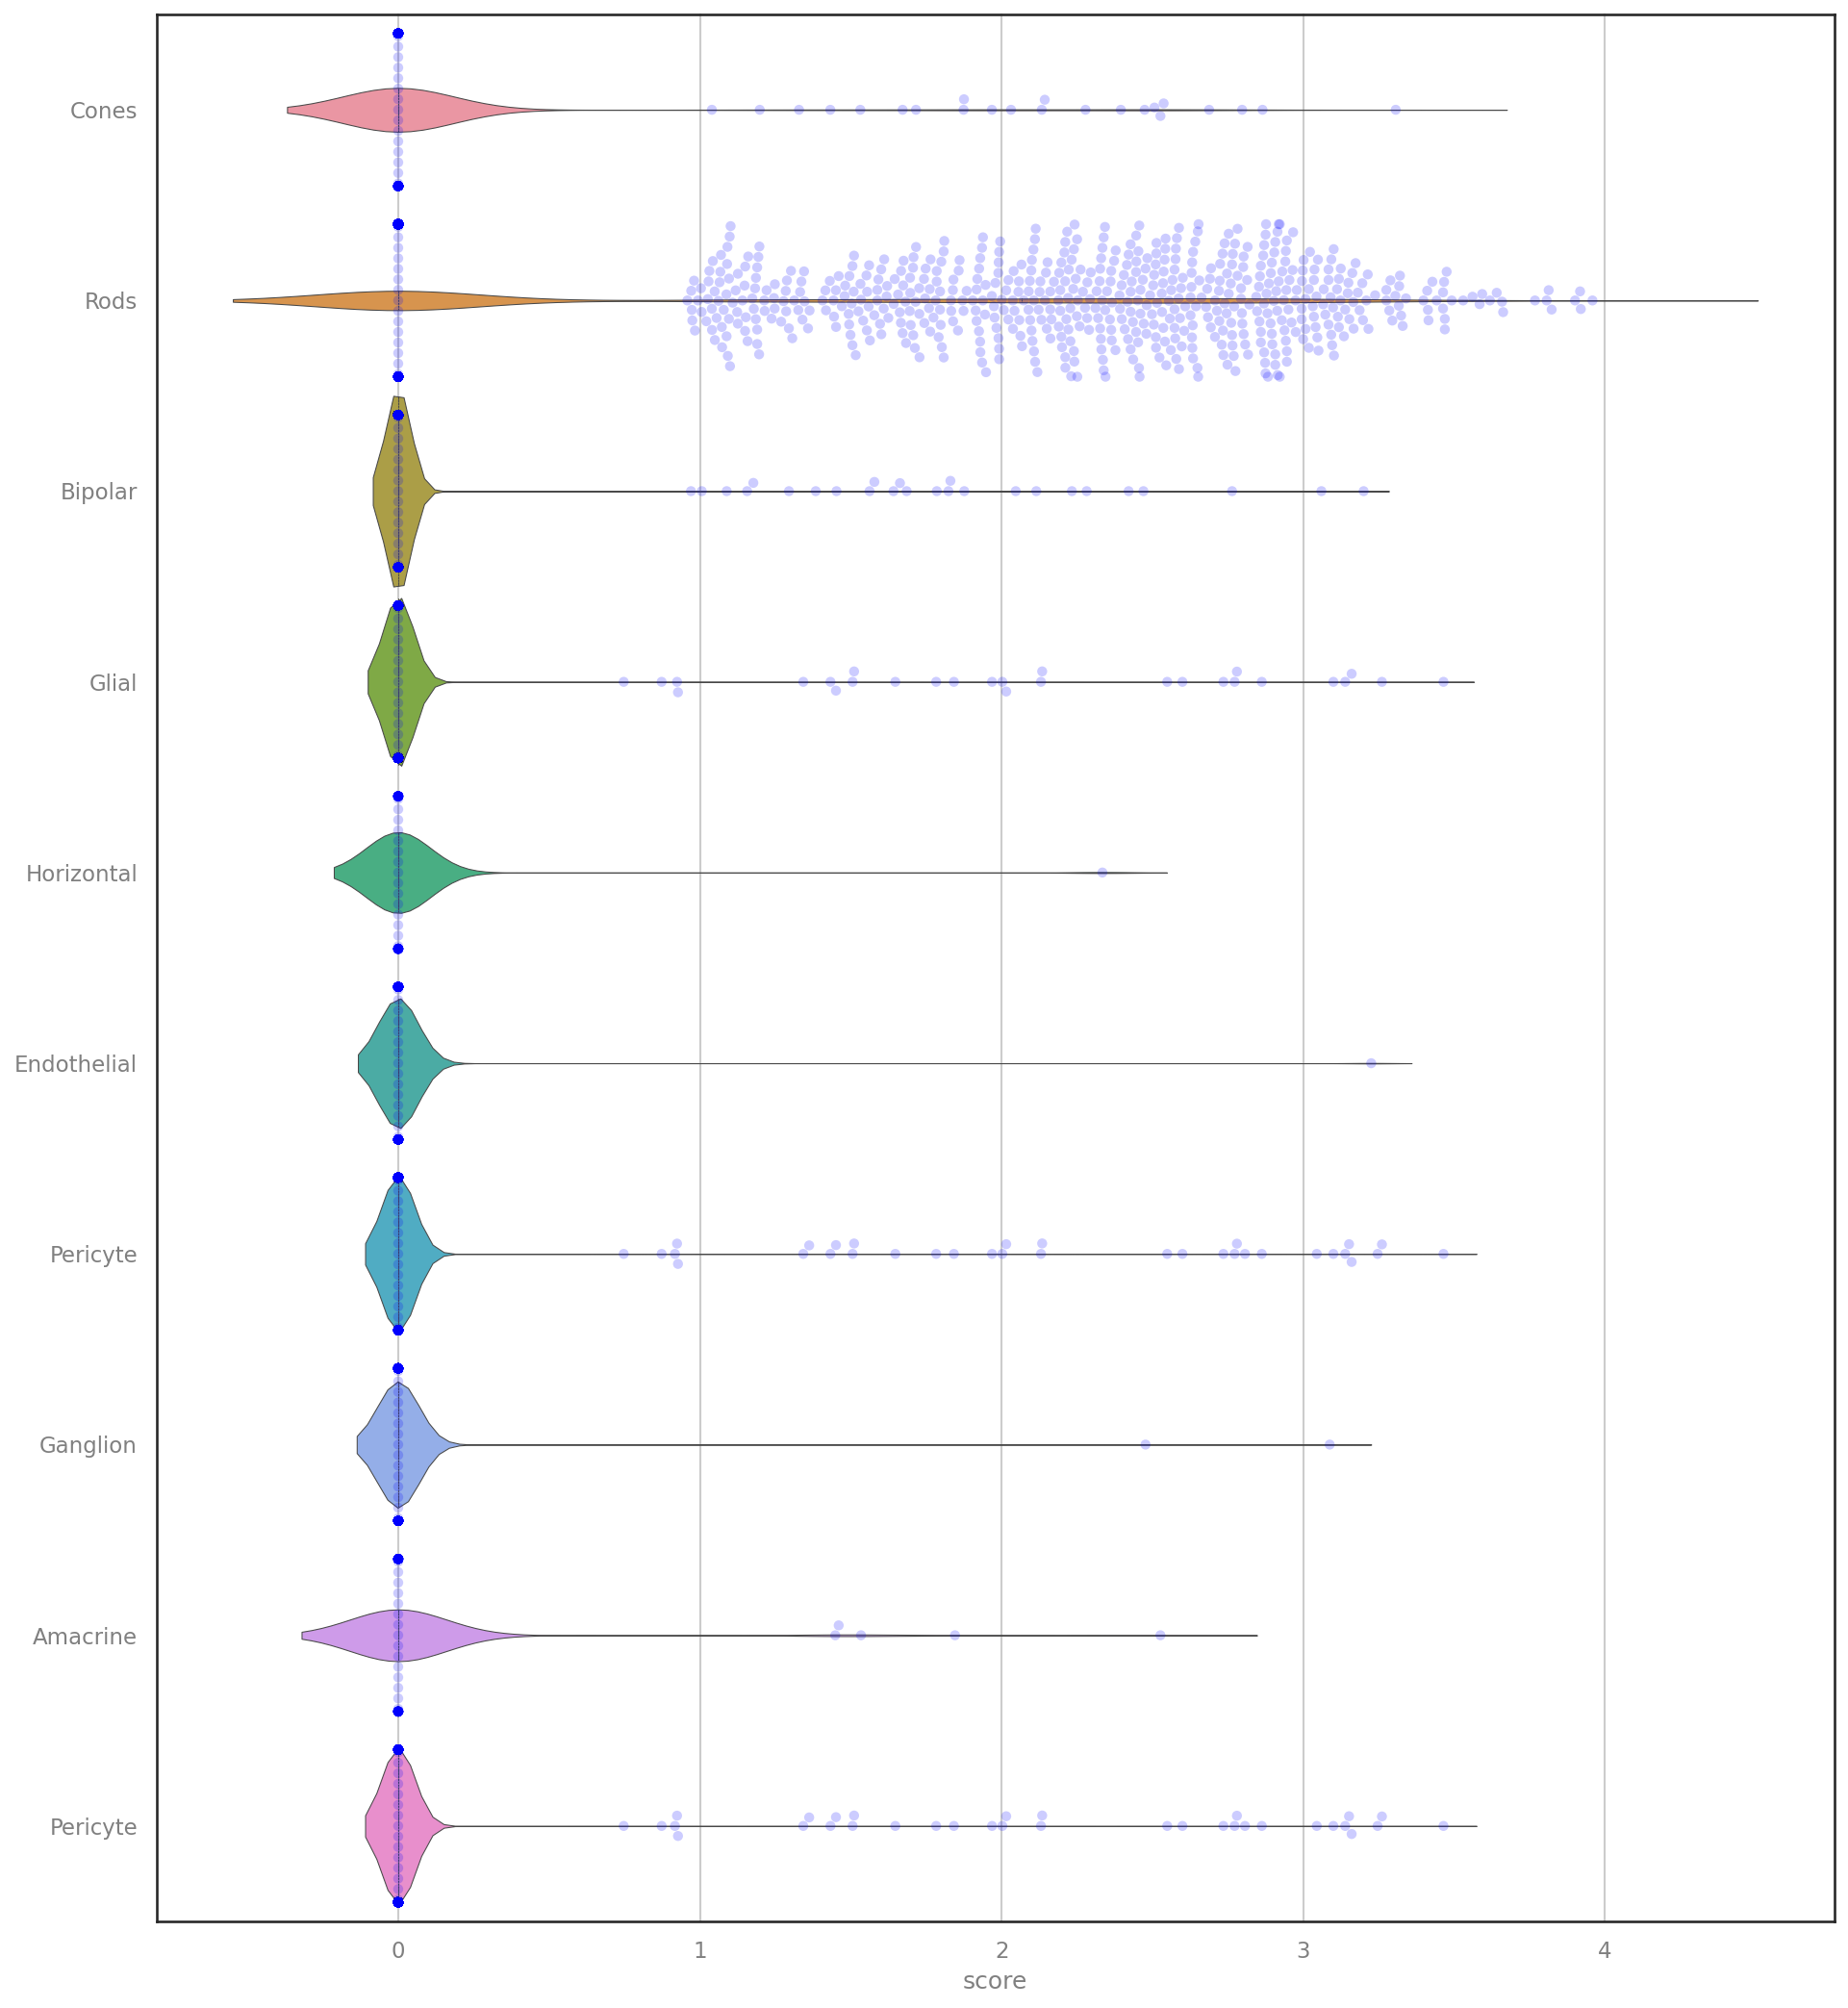

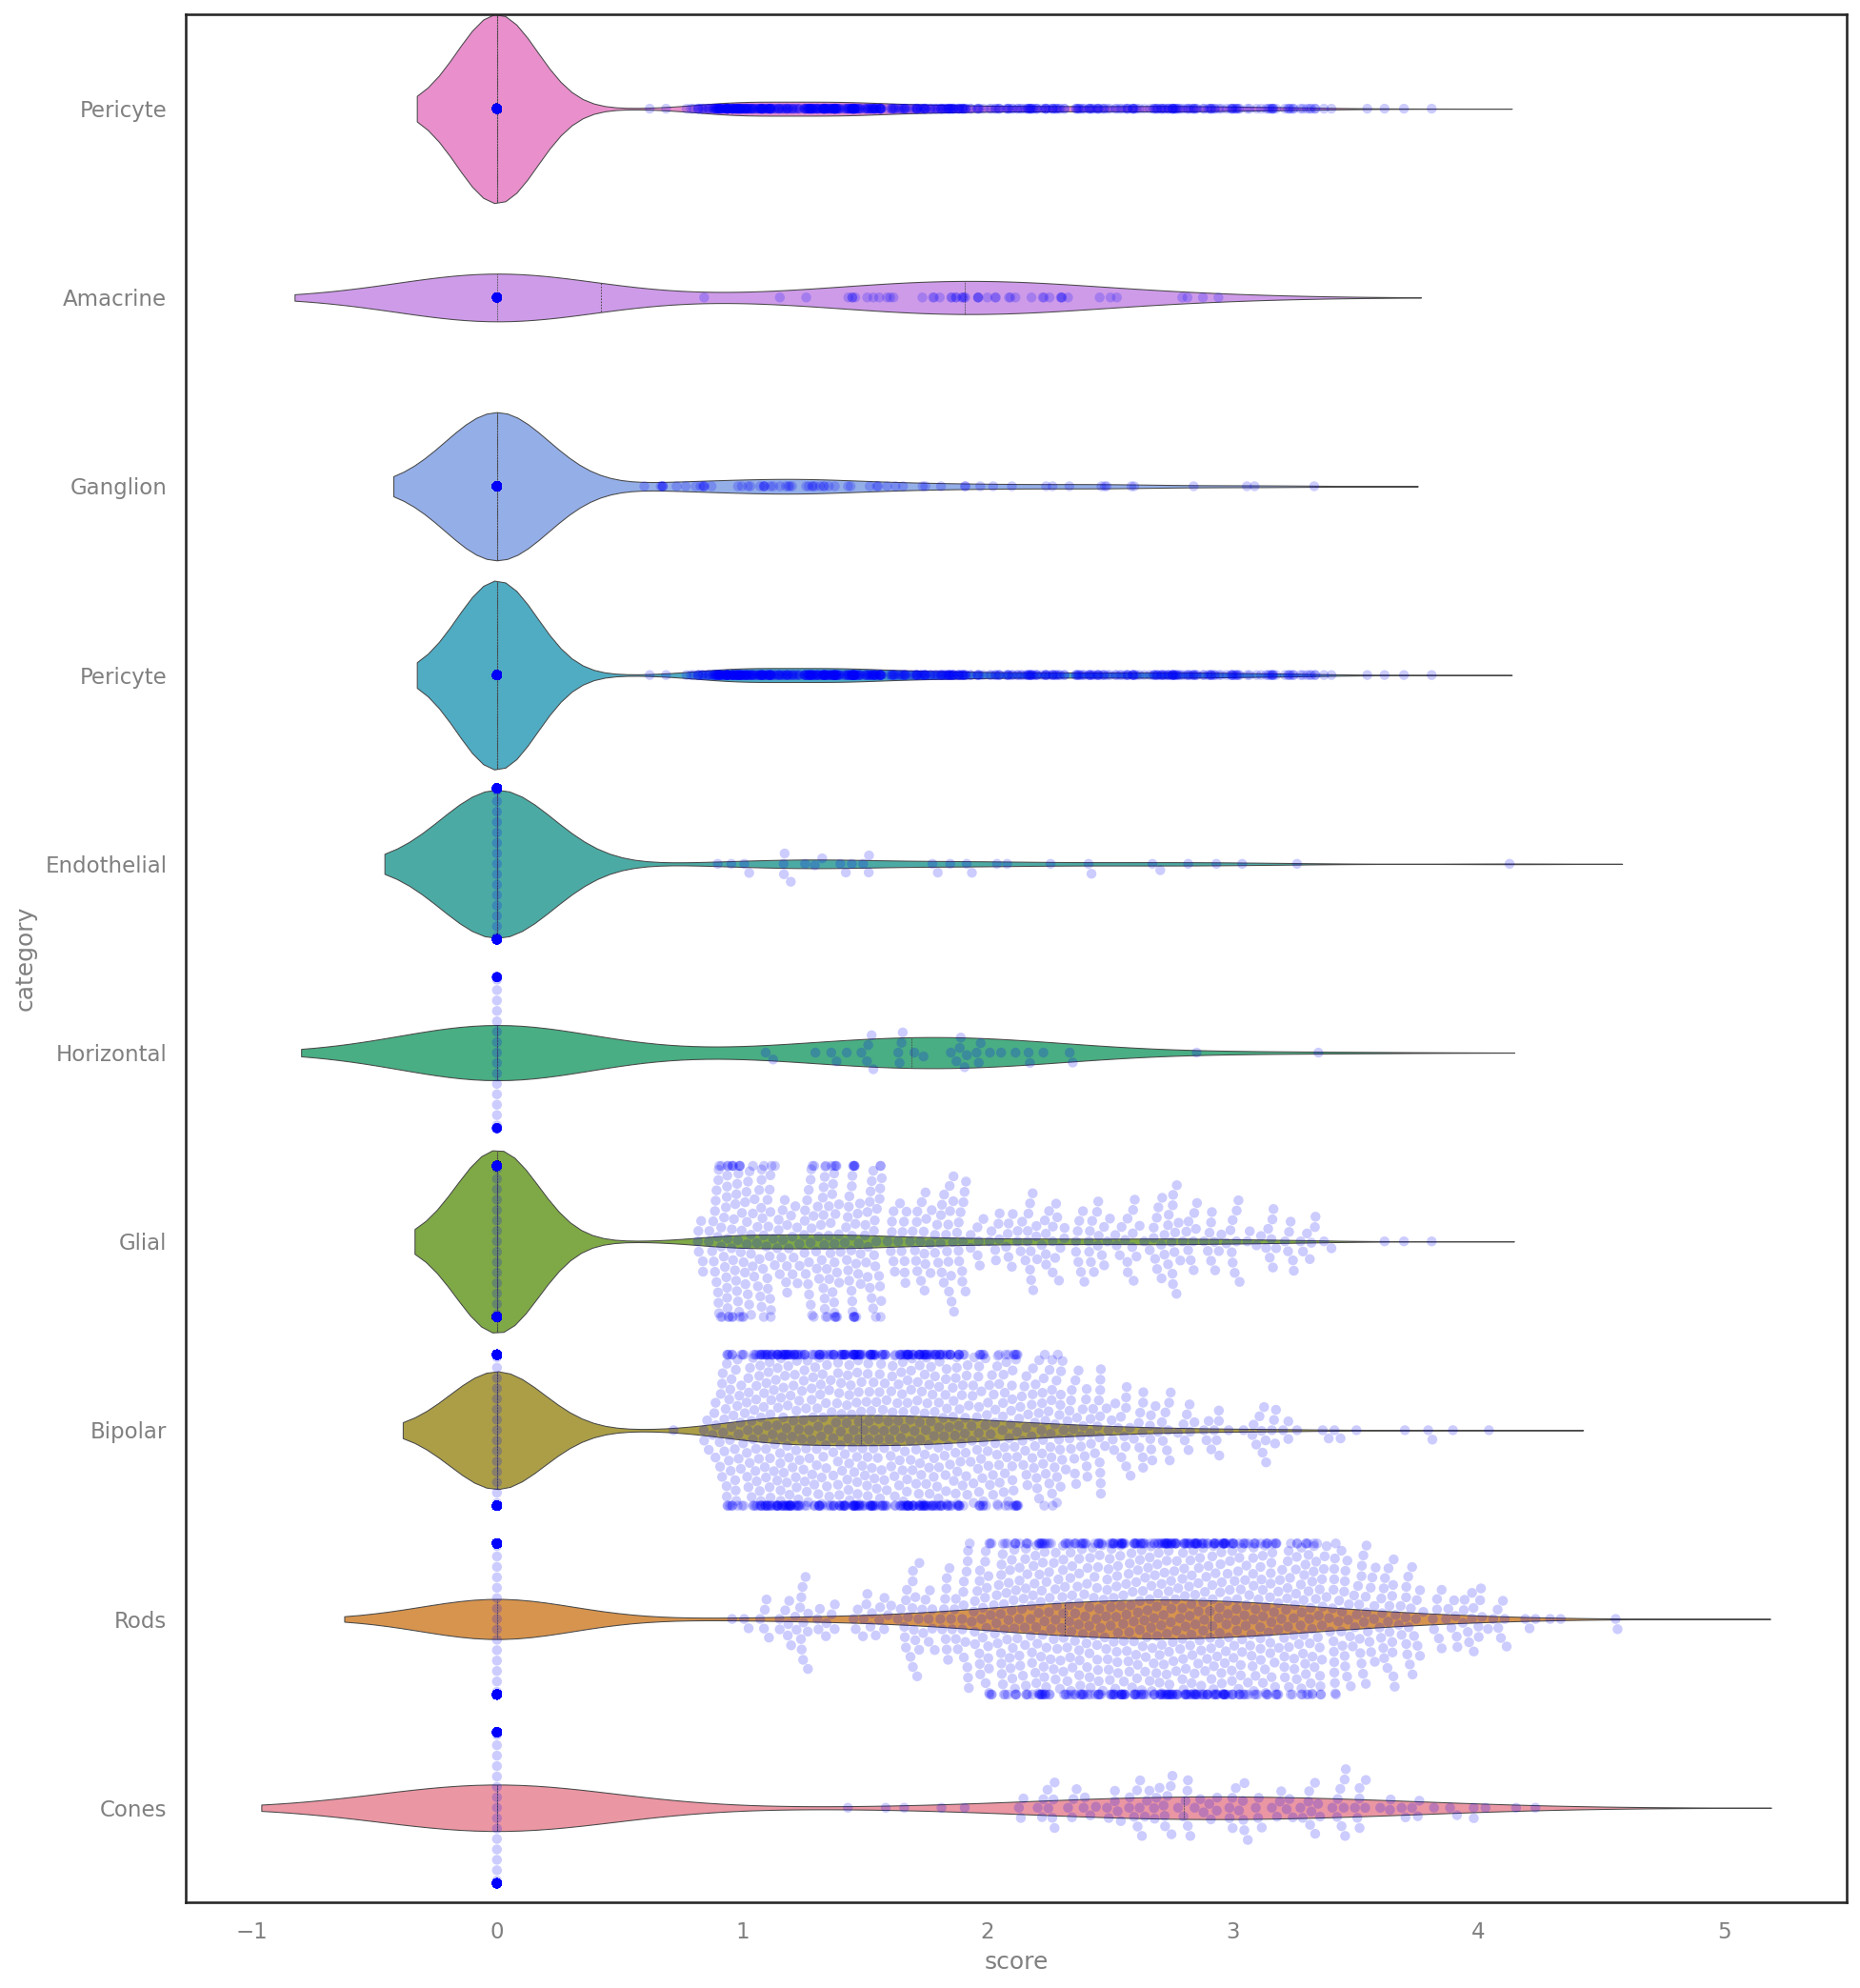

In [69]:
voigt_pdf = PdfPages("voigtPlotsBONE3.pdf")

wwc1_sarin = saveViolin("WWC1",["red","white","white", "white", "white"])
casz1_sarin = saveViolin("CASZ1",["white","red","white", "white", "white"])
ppef2_sarin = saveViolin("PPEF2",["white","red","white", "white", "white"])
akap9_sarin = saveViolin("AKAP9",["red","white","white", "white", "white"])

voigt_pdf.savefig(wwc1_sarin)
voigt_pdf.savefig(casz1_sarin)
voigt_pdf.savefig(ppef2_sarin)
voigt_pdf.savefig(akap9_sarin)
voigt_pdf.close()

### Old Plots

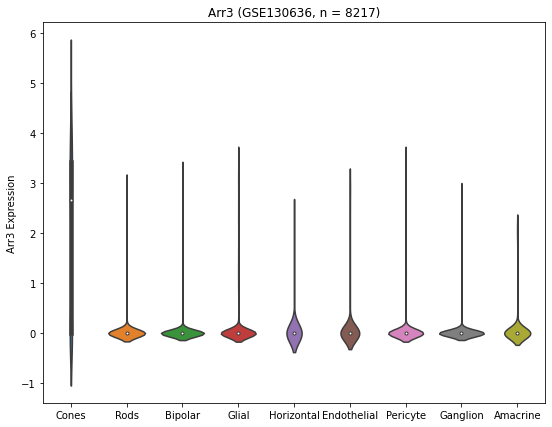

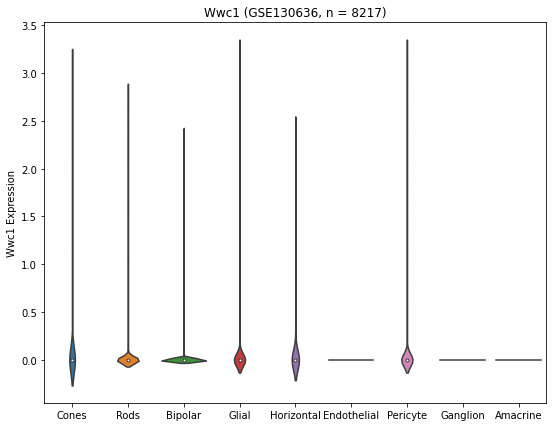

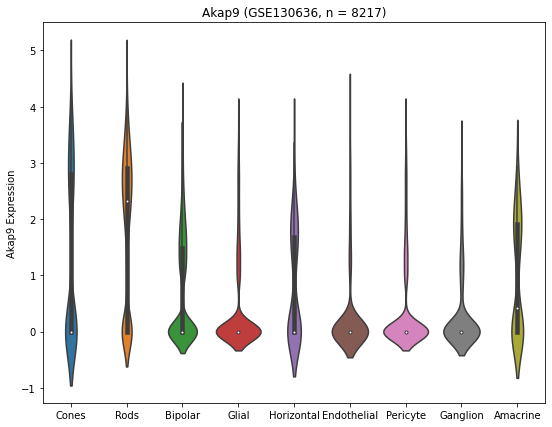

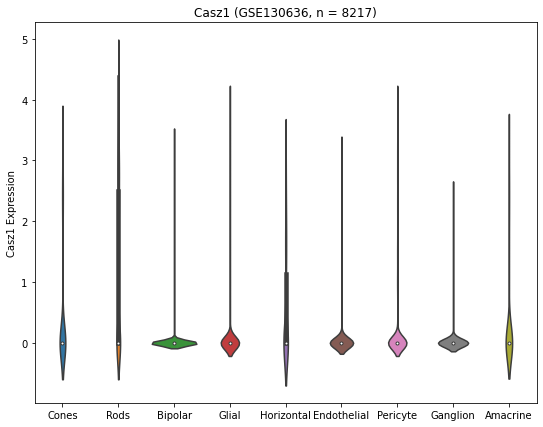

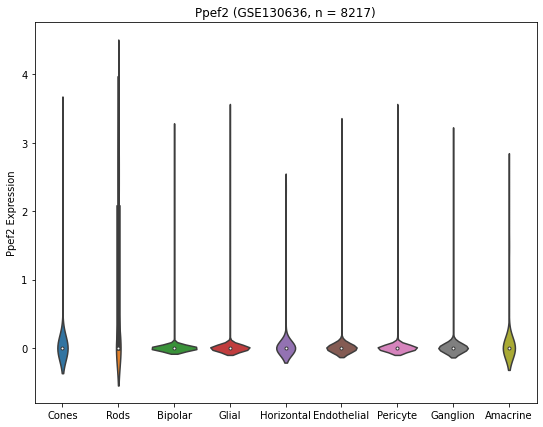

In [133]:
geneViolinplot("Arr3")
geneViolinplot("Wwc1")
geneViolinplot("Akap9")
geneViolinplot("Casz1")
geneViolinplot("Ppef2")

In [30]:
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages

voigt_pdf = PdfPages("voigtPlots.pdf")

arr3_voigt = geneViolinplot("Arr3")
wwc1_voigt = geneViolinplot("Wwc1")
akap9_voigt = geneViolinplot("Akap9")
casz1_voigt = geneViolinplot("Casz1")
ppef2_voigt = geneViolinplot("Ppef2")

voigt_pdf.savefig(arr3_voigt)
voigt_pdf.savefig(wwc1_voigt)
voigt_pdf.savefig(akap9_voigt)
voigt_pdf.savefig(casz1_voigt)
voigt_pdf.savefig(ppef2_voigt)

voigt_pdf.close()

#### Daum and Kim Time Course Datasets

In [39]:
db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
dbid = "RT39"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

atype = h.getSurvName("c developmental stage")
print(hu.uniq(atype))
P1 = [i for i in h.aRange() if atype[i] == 'P1']
P2 = [i for i in h.aRange() if atype[i] == 'P2']
P3 = [i for i in h.aRange() if atype[i] == 'P3']
P4 = [i for i in h.aRange() if atype[i] == 'P4']
P5 = [i for i in h.aRange() if atype[i] == 'P5']
P6 = [i for i in h.aRange() if atype[i] == 'P6'] 
P7 = [i for i in h.aRange() if atype[i] == 'P7']
P8 = [i for i in h.aRange() if atype[i] == 'P8']
P9 = [i for i in h.aRange() if atype[i] == 'P9']
P10 = [i for i in h.aRange() if atype[i] == 'P10']
P11 = [i for i in h.aRange() if atype[i] == 'P11']
P12 = [i for i in h.aRange() if atype[i] == 'P12']
adult = [i for i in h.aRange() if atype[i] == 'adult']

def geneViolinplot(geneName):
    expr = h.getExprData(geneName)
    expr_1 = np.array([float(expr[i]) for i in P1])
    expr_2 = np.array([float(expr[i]) for i in P2])
    expr_3 = np.array([float(expr[i]) for i in P3])
    expr_4 = np.array([float(expr[i]) for i in P4])
    expr_5 = np.array([float(expr[i]) for i in P5])
    expr_6 = np.array([float(expr[i]) for i in P6])
    expr_7 = np.array([float(expr[i]) for i in P7])
    expr_8 = np.array([float(expr[i]) for i in P8])
    expr_9 = np.array([float(expr[i]) for i in P9])
    expr_10 = np.array([float(expr[i]) for i in P10])
    expr_11 = np.array([float(expr[i]) for i in P11])
    expr_12 = np.array([float(expr[i]) for i in P12])
    expr_adult = np.array([float(expr[i]) for i in adult])
    
    data = [expr_1, expr_2, expr_3, expr_4, expr_5, expr_6, expr_7, \
            expr_8, expr_9, expr_10, expr_11, expr_12, expr_adult]
    expr_df = pd.DataFrame(data)
    expr_df = expr_df.transpose()
    expr_df.columns = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", \
                       "P9", "P10", "P11", "P12", "Adult"]
    fig, ax = plt.subplots(figsize = (9.5,5))
    ax.set_title(geneName+" (GSE97534, n = 42)")
    ax.set_ylabel(geneName+" Expression")
    sns.violinplot(ax=ax, data=expr_df.iloc[:,0:9])
    return fig

[7, 'c developmental stage', 'P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'adult']


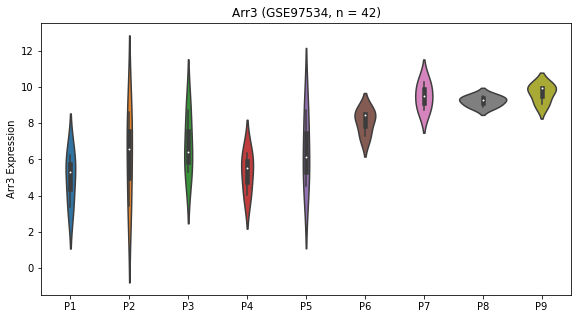

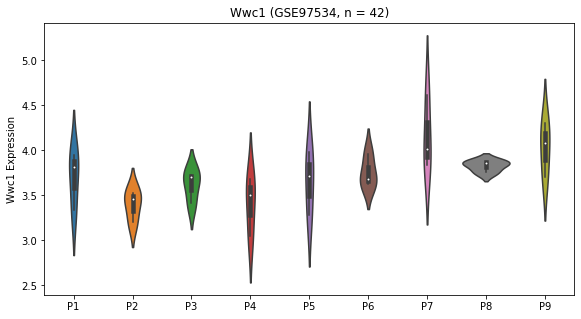

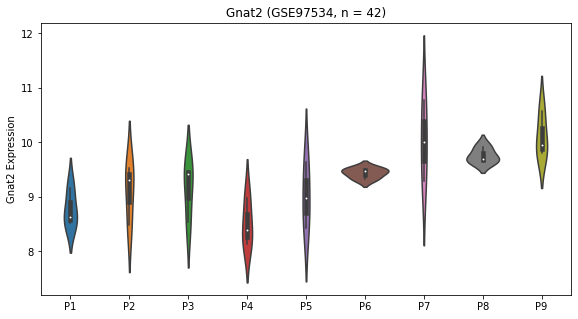

In [40]:
daum_pdf = PdfPages("daumPlots.pdf")

arr3_daum = geneViolinplot("Arr3")
wwc1_daum = geneViolinplot("Wwc1")
gnat2_daum = geneViolinplot("Gnat2")

daum_pdf.savefig(arr3_daum)
daum_pdf.savefig(wwc1_daum)
daum_pdf.savefig(gnat2_daum)

daum_pdf.close()